In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np

# Constants

In [2]:
sample_rate = 44100
hop_size = 441*2
hidden_mod = 3
maximum = 32
width = 4
ds_path = './datasets/VN/ds.pkl'
model_path = './models/VN/model04_'

# Data Class

In [3]:
import os
import re
import json
import math
import cv2
import subprocess as sp
from osr2mp4.EEnum.EReplay import Replays
from osr2mp4.osr2mp4 import Osr2mp4
import torch
import torchvision.io as vision
import torchvision.transforms as transforms

In [4]:
class OSR():
    def __init__(self, beatmap_dir, beatmap, sample_rate=44100, hop_size=441, skin=None,
                 width=4,
                 tmp='./tmp', vtmp='./vid', atmp='./wav'):
        self.beatmap = beatmap
        self.beatmap_dir = beatmap_dir
        self.beatmap_path = os.path.join(self.beatmap_dir, self.beatmap)
        self.sample_rate = sample_rate
        self.hop_size = hop_size
        self.rate = int(sample_rate / hop_size)
        self.fps = self.rate
        self.tmp = tmp
        self.vtmp = vtmp
        self.atmp = atmp
        self.width = 4
        self.skin = skin
        self.data_json = os.path.join(self.tmp, self.beatmap + '.json')
        self.video_path = os.path.join(self.vtmp, self.beatmap + '.avi')
        
        self.replay_info = None
        self.osr2mp4 = None
        self.video = None
        self.hitobjects = None
        self.cursorstream = None
        self.timestamp = None
                
    def run_osr2mp4(self):
        d = json.load(open('data.json', 'r'))
        f = open(self.data_json, 'w')
        d['Beatmap path'] = self.beatmap_path
        if self.skin is not None:
            d['Skin path'] = self.skin
        d['FPS'] = self.fps
        d['Output path'] = self.video_path
        json.dump(d, f)
        f.close()
                 
        self.osr2mp4 = Osr2mp4(filedata=self.data_json, filesettings='settings.json', filepp='ppsettings.json', 
                               filestrain='strainsettings.json', logtofile=True)
        while True:
            if self.osr2mp4.replay_info.play_data[-1][Replays.CURSOR_X] == 0 and self.osr2mp4.replay_info.play_data[-1][Replays.CURSOR_Y] == 0:
                self.osr2mp4.replay_info.play_data = self.osr2mp4.replay_info.play_data[0:-1]
            else:
                break
        
    def create_vid(self):
        if self.osr2mp4 is None:
            self.run_osr2mp4()
        cmd = ['python', 'create_vid.py', self.data_json]
        proc = sp.Popen(cmd)
        proc.wait()
        
    def parse_timings(self):
        if self.video is None:
            self.get_video()
        self.beat_len = []
        self.timestamp = []
        f = open(self.beatmap_path)
        for l in f:
            if re.match(r'BeatDivisor.*', l):
                self.BeatDivisor = int(l.split(':')[1])
                break
        f.seek(0)
        for l in f:
            if re.match(r'\[TimingPoints\]', l):
                break
        for l in f:
            if l == "\n":
                break
            a = l.split(',')
            if float(a[1]) < 0:
                continue
            self.beat_len.append(float(a[1]))
            self.timestamp.append(float(a[0]))
        self.timestamp.append(int(self.video[1].shape[1] / self.video[2]['audio_fps'] * 1000))
        f.close()
    
    def parse_hitobjects(self):
        self.hitobjects = []
        f = open(self.beatmap_path)
        for l in f:
            if re.match(r'ApproachRate.*', l):
                AR = float(l.split(':')[1])
                if AR < 5.0:
                    preempt = 1200 + 600 * (5 - AR) / 5
                    fadein = 800 + 400 * (5 - AR) / 5
                else:
                    preempt = 1200 - 750 * (AR - 5) / 5
                    fadein = 800 - 500 * (AR - 5) / 5
                self.preempt = preempt - fadein*0.1
                break
        f.seek(0)
        for l in f:
            if re.match(r'SliderMultiplier.*', l):
                self.sliderMultiplier = float(l.split(':')[1])
                break
        f.seek(0)
        for l in f:
            if re.match(r'\[HitObjects\]', l):
                break
        for l in f:
            self.hitobjects.append(l.split(','))
        f.close()
    
    def parse_beatmap(self):
        self.parse_timings()
        self.parse_hitobjects()
        
    def create_cursor_peak(self, y, i):
        alen = len(y)
        w = self.width/2/2
        
        def func(x):
            return math.exp(-j**2/w**2)
        
        j = 0 
        while i+j > 0 and abs(j) <= w*2:
            f = func(j)
            y[i+j][Replays.KEYS_PRESSED] = max(y[i+j][Replays.KEYS_PRESSED], f, 0)
            j -= 1
        j = 0
        while i+j < alen and abs(j) <= w*2:
            f = func(j)
            y[i+j][Replays.KEYS_PRESSED] = max(y[i+j][Replays.KEYS_PRESSED], f, 0)
            j += 1
    
    def process_beatobjects(self):
        pass
    
    def process_hitobjects(self):
        if self.hitobjects is None:
               self.parse_beatmap()
        self.hitobjStream = [None] * math.ceil(self.timestamp[-1] * 0.001 * self.rate)
    
    def process_clicks(self):
        pass
    
    def process_cursor(self):
        if self.osr2mp4 is None:
            self.run_osr2mp4()
        n = math.ceil((self.osr2mp4.replay_info.play_data[-1][Replays.TIMES] - self.get_offset()) * 0.001 * self.fps)
        self.cursorstream = [None] * n
        #self.cursorstream = np.zeros((n, 3))
        
        for j in range(len(self.osr2mp4.replay_info.play_data) - 1):
            a = self.osr2mp4.replay_info.play_data[j]
            b = self.osr2mp4.replay_info.play_data[j+1]
            delta = (b[Replays.TIMES] - a[Replays.TIMES]) * 0.001 * self.fps
            xdist = b[Replays.CURSOR_X] - a[Replays.CURSOR_X]
            ydist = b[Replays.CURSOR_Y] - a[Replays.CURSOR_Y]
            stime = (a[Replays.TIMES] - self.get_offset()) * 0.001 * self.fps
            x = a[Replays.CURSOR_X]
            y = a[Replays.CURSOR_Y]
            
            e = np.array([0.0, 0.0, 0])           
            for t in range(math.ceil(delta)):
                e[Replays.CURSOR_X] = x + xdist/delta*t
                e[Replays.CURSOR_Y] = y + ydist/delta*t
                self.cursorstream[int(stime + t)] = torch.tensor(e, dtype=torch.float)
            e[Replays.KEYS_PRESSED] = a[Replays.KEYS_PRESSED]
            e[Replays.CURSOR_X] = a[Replays.CURSOR_X]
            e[Replays.CURSOR_Y] = a[Replays.CURSOR_Y]
            self.cursorstream[int((a[Replays.TIMES] - self.get_offset()) * 0.001 * self.fps)] = torch.tensor(e, dtype=torch.float)
            e[Replays.KEYS_PRESSED] = b[Replays.KEYS_PRESSED]
            e[Replays.CURSOR_X] = b[Replays.CURSOR_X]
            e[Replays.CURSOR_Y] = b[Replays.CURSOR_Y]
            self.cursorstream[int((b[Replays.TIMES] - self.get_offset()) * 0.001 * self.fps)] = torch.tensor(e, dtype=torch.float)
        
        for i in range(len(self.cursorstream)):
            if self.cursorstream[i] is None:
                self.cursorstream[i] = torch.tensor([0.0, 0.0, 0])
        r = copy.deepcopy(self.cursorstream)
        for i in range(len(self.cursorstream)):
            if r[i][Replays.KEYS_PRESSED] != 0:
                self.create_cursor_peak(self.cursorstream, i)
        #for i in range(len(self.cursorstream)):
        #    self.cursorstream[i] = torch.tensor(self.cursorstream[i])
        
    def process_events(self):
        self.process_clicks()
        self.process_cursor()
        
    def read_video(self, scale=1):
        if not os.path.exists(self.video_path):
            self.create_vid()
        #self.video = vision.read_video(self.video_path)
        transform = transforms.ToTensor()
        frames = []
        vc = cv2.VideoCapture(self.video_path)
        while True:
            r, f = vc.read()
            f = cv2.resize(f, (0,0), fx=scale, fy=scale)
            frames.append(transform(f))
            if r is False:
                break
        return torch.stack(frames)
        
    def queue_vid(self):
        if not os.path.exists(self.video_path):
            self.create_vid()   
        return self.video_path
    
    def get_offset(self):
        if self.osr2mp4 is None:
            self.run_osr2mp4()
        return self.osr2mp4.replay_info.play_data[0][Replays.TIMES]
    
    def get_beatobjects(self):
        if self.beatobjStream is None:
            self.process_beatobjects()
        stream = [None] * len(self.beatobjStream)
        for i in range(len(self.beatobjStream)):
            if self.beatobjStream[i] == [] or self.beatobjStream == None:
                h = np.array([0], dtype=np.float32)
            else:
                h = np.array(self.beatobjStream[i], dtype=np.float32)
            stream[i] = torch.tensor(np.pad(h, (0, 64 - h.shape[0])))
        return torch.stack(stream)
        
    def get_hitobjects(self):
        if self.hitobjStream is None:
            self.process_hitobjects()
        stream = [None] * len(self.hitobjStream)
        for i in range(len(self.hitobjStream)):
            if self.hitobjStream[i] == [] or self.hitobjStream == None:
                h = np.array([0], dtype=np.float32)
            else:
                h = np.array(self.hitobjStream[i], dtype=np.float32)
            stream[i] = torch.tensor(np.pad(h, (0, 64 - h.shape[0])))
        return torch.stack(stream)
    
    def get_cursor(self):
        if self.cursorstream is None:
            self.process_events()
        return torch.stack(self.cursorstream)
        
    def get_video(self, scale=1):
        if self.video is None:
            self.read_video(scale=1)
        return self.video

# Dataset

In [5]:
import glob
import copy
import traceback
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import cv2
import matplotlib.pyplot as plt

In [6]:
class OSR_Dataset(Dataset):
    def __init__(self, beatmap_dir, sample_rate=44100, hop_size=441, seq_dur=10, scale=1, hidden_mod=0, maximum=100):
        self.beatmap_dir = beatmap_dir
        self.sample_rate = sample_rate
        self.hop_size = hop_size
        self.seq_len = int(seq_dur * sample_rate / hop_size)
        self.hidden_mod = hidden_mod
        self.maximum = maximum
        self.scale = scale
        
        self.osrs = []
        
        if beatmap_dir is None:
            self.v = []
            self.c = []
            return
        
        j = 0
        def parse_beatmaps(j):
            for r, dirs, _ in os.walk(beatmap_dir):
                for dir in dirs:
                    for root, _, files in os.walk(os.path.join(r, dir)):
                        for f in files:
                            if re.match(r'.*osu$', f):
                                if self.hidden_mod == 0 or j % self.hidden_mod != 0:
                                    self.osrs.append(OSR(root, f, sample_rate=sample_rate, hop_size=hop_size))
                                else:
                                    self.osrs.append(OSR(root, f, sample_rate=sample_rate, hop_size=hop_size, skin='./skin_hidden'))
                                if j == self.maximum:
                                    return j
                                j += 1
            return j
        j = parse_beatmaps(j)
        
        self.v = [None] * j
        self.c = [None] * j
        
        def process(i):
            m = self.osrs[i]
            self.osrs[i] = None;
            try:
                print(str(i) + '/' + str(j-1), m.beatmap)
                self.v[i] = copy.deepcopy(m.queue_vid())
                self.c[i] = copy.deepcopy(m.get_cursor())
            except Exception as e:
                traceback.print_exc()
                print("pruning:", m.beatmap)
                self.v[i] = None
                self.c[i] = None
            del m
        
        list(map(process, range(j)))
        
    def take(self, ds, i, j):
        self.v = ds.v[i:j]
        self.c = ds.c[i:j]

    def __len__(self):
        return len(self.v)

    def __getitem__(self, i):
        if self.seq_len == 0:
            return None
        
        transform = transforms.ToTensor()
        j = np.random.randint(0, self.c[i].shape[0] - self.seq_len)
        vc = cv2.VideoCapture(self.v[i])
        vc.set(cv2.CAP_PROP_POS_FRAMES, j)
        #for k in range(j):
        #    _, _ = vc.read()
        
        f = [None] * self.seq_len
        for k in range(self.seq_len):
            frame = vc.read()[1]
            frame = cv2.resize(frame, (0,0), fx=self.scale, fy=self.scale)
            f[k] = transform(frame)
        
        c = self.c[i][j: j+self.seq_len]
        cy = torch.div(c[:,Replays.CURSOR_Y], 384) #, dtype=c.type())
        c[:,1] = torch.div(c[:,Replays.CURSOR_X], 512) #, dtype=c.type())
        c[:,0] = cy
        
        return (torch.stack(f), c) #self.c[i][j: j+self.seq_len])

# Testing

In [6]:
s = OSR_Dataset('../ex/beatmaps', sample_rate=44100, hop_size=441*2, hidden_mod=0, maximum=1)

0/0 sasakure.UK - Spider Thread Monopoly feat. Hatsune Miku (Mishima Yurara) [Milan-'s Hard].osu


(600, 1024, 3)
tensor(0.4718, dtype=torch.float64) tensor(0.4639, dtype=torch.float64)
(242, 142)


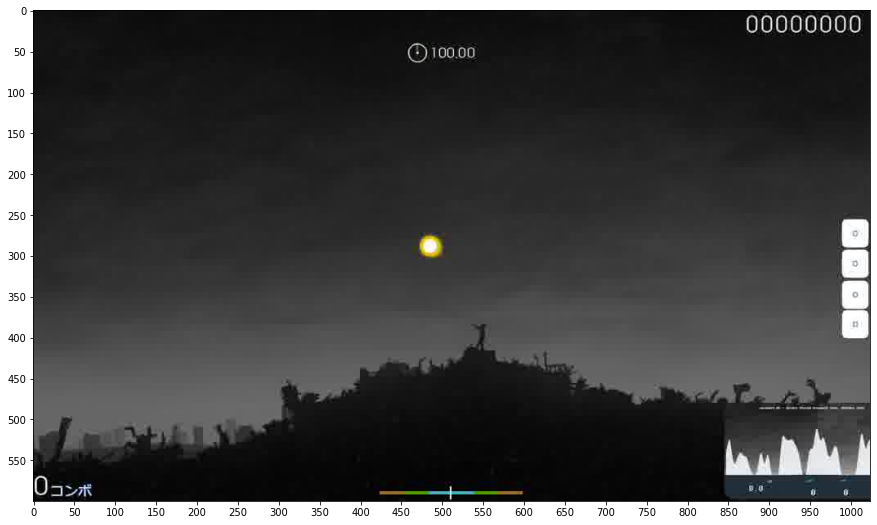

In [7]:
import matplotlib.pyplot as plt

import op

op.h = 600 / 2
op.w = 1024 / 2
op.calratio()

e = s[0]
print(e[0][0].permute(1, 2, 0).numpy().shape)

plt.rcParams["figure.figsize"] = (15, 15)

plt.xticks(np.arange(0, e[0][0].permute(1, 2, 0).numpy().shape[1], 50))
plt.yticks(np.arange(0, e[0][0].permute(1, 2, 0).numpy().shape[0], 50))

plt.imshow(cv2.cvtColor(e[0][0].permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB))
print(e[1][0][1], e[1][0][0])
print(op.cor(e[1][0][1] * 512, e[1][0][0] * 384))
#print(op.cor(e[1][0][1], e[1][0][0]))
#for x in e[1][0:10]:
    #print(op.cor(x[0], x[1]))

# Process Data

In [55]:
import time

In [35]:
ds = OSR_Dataset('../beatmaps', sample_rate=sample_rate, hop_size=hop_size, hidden_mod=hidden_mod, maximum=maximum)

0/31 Chata - Engage (Lasse) [Insane].osu
1/31 Mimi - Surrealism (feat. ZAT) (-Tatsuo) [no mania].osu
2/31 sana - kanojo wa tabi ni deru (Firika) [Insane].osu
3/31 Ishida Youko - To the Promised Sky ~The place that I was~ (caren) [Collabo].osu
4/31 StylipS - Prism Sympathy(Asterisk Remix) (iMage--) [Kaleid Liner].osu
5/31 Cranky - Chandelier - King (Mao) [Gero's Insane].osu
6/31 senya - Akatsuki no Suiheisen ni (Satellite) [Zweib's Insane].osu
7/31 Tadokoro Azusa - 1HOPE SNIPER (Sotarks) [NiNo's Insane].osu
8/31 fripSide - future gazer (TV Size) (alacat) [Insane].osu
9/31 cYsmix - bells! (Gero) [normal!].osu
10/31 Yazawa Nico (CV.Tokui Sora) - Nicopuri Joshidou (yf_bmp) [z1085684963's Insane].osu
11/31 Hamburgaga - Watame Internet Connection Race (CE6A) [Insane].osu
12/31 xi - Parousia -LAST JUDGMENT- (Zapy) [Retribution].osu
13/31 Shiena Nishizawa - Meaning (Taeyang) [xChippy's Insane].osu
14/31 namirin - Hitokoto no Kyori (sahuang) [Linadeft's Insane].osu
15/31 Narushima - Gothic and 

In [36]:
start = time.time()

torch.save(ds, ds_path)

end = time.time()
print(end - start, 'secs')

0.01752758026123047 secs


# Load Daaset

In [7]:
ds = torch.load(ds_path)

# Model

In [8]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as nnF

from attention.attention import SpatialAttn, ProjectorBlock

In [9]:
class VN(nn.Module):
    def __init__(self, dim_in, device):
        super(VN, self).__init__()
        
        self.device = device
        self.lstmA_size = 128
        self.lstmA_layers = 1
        self.dim_out = 2

        cA = [0,0]
        W = dim_in[0]
        K = cAK = 3
        P = cAP = 1
        S = cAS = 1
        w = int(((W - K + 2*P)/S) + 1)
        k = mAk = 2
        p = mAp = 0
        s = mAs = 2
        m = int(((w - k + 2*p)/s) + 1)
        cA[0] = w
        
        W = dim_in[1]
        K = cAK
        P = cAP
        S = cAS
        w = int(((W - K + 2*P)/S) + 1)
        k = mAk
        p = mAp
        s = mAs
        m = int(((w - k + 2*p)/s) + 1)
        cA[1] = w
        
        cB = [0,0]
        W = cA[0]
        K = cBK = 3
        P = cBP = 1
        S = cBS = 1
        w = int(((W - K + 2*P)/S) + 1)
        k = mBk = 3
        p = mBp = 0
        s = mBs = 2
        m = int(((w - k + 2*p)/s) + 1)
        cB[0] = m
        
        W = cA[1]
        K = cBK
        P = cBP
        S = cBS
        w = int(((W - K + 2*P)/S) + 1)
        k = mBk
        p = mBp
        s = mBs
        m = int(((w - k + 2*p)/s) + 1)
        cB[1] = m
        
        self.convA1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.convB1 = nn.Conv2d(16, 16, 3, stride=1, padding=1) 
        self.maxPB1 = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.convA2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.convB2 = nn.Conv2d(32, 32, 3, stride=1, padding=1) 
        self.maxPB2 = nn.MaxPool2d(3, stride=2, padding=1)

        self.convA3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.convB3 = nn.Conv2d(64, 64, 3, stride=1, padding=1) 
        self.maxPB3 = nn.MaxPool2d(3, stride=2, padding=1)
       
        self.lstmA = nn.LSTM(38912, hidden_size=self.lstmA_size, num_layers=self.lstmA_layers,
                             batch_first=True, bidirectional=False)
        self.linearA = nn.Linear(self.lstmA_size, 32)
        self.linearB = nn.Linear(32, self.dim_out)
        
        self.hiddenA = None
        
    def _make_layer(self, in_features, out_features, blocks, pool=False):
        layers = []
        for i in range(blocks):
            conv2d = nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, padding=1, bias=False)
            layers += [conv2d, nn.BatchNorm2d(out_features), nn.ReLU(inplace=True)]
            in_features = out_features
            if pool:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        return nn.Sequential(*layers)
        
    def init_hidden(self, batch_size):
        h = torch.zeros(self.lstmA_layers, batch_size, self.lstmA_size).to(self.device)
        c = torch.zeros(self.lstmA_layers, batch_size, self.lstmA_size).to(self.device)
        self.hiddenA = (h, c)
 
    def forward(self, x):
        s = x.shape
        x = torch.reshape(x, (s[0] * s[1], s[2], s[3], s[4]))
        
        x = self.convA1(x)
        x = nnF.relu(x)
        x = self.convB1(x)
        x = nnF.relu(x)
        x = self.maxPB1(x)
        
        x = self.convA2(x)
        x = nnF.relu(x)
        x = self.convB2(x)
        x = nnF.relu(x)
        x = self.maxPB2(x)
        
        x = self.convA3(x)
        x = nnF.relu(x)
        x = self.convB3(x)
        x = nnF.relu(x)
        x = self.maxPB3(x)
        
        x = torch.flatten(x, start_dim=1)
        x = torch.reshape(x, (s[0], s[1], x.shape[-1]))
        
        x, self.hiddenA = self.lstmA(x, self.hiddenA)
        x = self.linearA(x)
        x = nnF.relu(x)
        x = self.linearB(x)
        
        return x

# Training

In [10]:
import torch
from torch.utils.data import DataLoader
from torchinfo import summary
from qqdm.notebook import qqdm
import matplotlib.pyplot as plt
import op

In [11]:
batch_size = 1
scale = 1/4
dim_in = (int(600 * scale), int(1024 * scale))
seq_dur = 2

In [12]:
device = torch.device('cuda')

In [13]:
epoch_cum = 0
val_hist = []
train_hist = []
vn = VN(dim_in=dim_in, device=device)
vn.to(device)

VN(
  (convA1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convB1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPB1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (convA2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convB2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPB2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (convA3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convB3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPB3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (lstmA): LSTM(38912, 128, batch_first=True)
  (linearA): Linear(in_features=128, out_features=32, bias=True)
  (linearB): Linear(in_features=32, out_features=2, bias=True)
)

In [14]:
vn.init_hidden(1)
summary(vn, input_size=(1, 1, 3, dim_in[0], dim_in[1]), col_width=16,
           col_names=["input_size",
                "output_size",
                "num_params",
                "kernel_size",
                "mult_adds",])

Layer (type:depth-idx)                   Input Shape      Output Shape     Param #          Kernel Shape     Mult-Adds
VN                                       --               --               --               --               --
├─Conv2d: 1-1                            [1, 3, 150, 256] [1, 16, 150, 256] 448              [3, 16, 3, 3]    17,203,200
├─Conv2d: 1-2                            [1, 16, 150, 256] [1, 16, 150, 256] 2,320            [16, 16, 3, 3]   89,088,000
├─MaxPool2d: 1-3                         [1, 16, 150, 256] [1, 16, 75, 128] --               --               --
├─Conv2d: 1-4                            [1, 16, 75, 128] [1, 32, 75, 128] 4,640            [16, 32, 3, 3]   44,544,000
├─Conv2d: 1-5                            [1, 32, 75, 128] [1, 32, 75, 128] 9,248            [32, 32, 3, 3]   88,780,800
├─MaxPool2d: 1-6                         [1, 32, 75, 128] [1, 32, 38, 64]  --               --               --
├─Conv2d: 1-7                            [1, 32, 38, 64]  [1,

In [15]:
train_ds = OSR_Dataset(None, sample_rate=sample_rate, hop_size=hop_size, seq_dur=seq_dur, scale=scale, hidden_mod=hidden_mod, maximum=maximum)
val_ds = OSR_Dataset(None, sample_rate=sample_rate, hop_size=hop_size, seq_dur=seq_dur, scale=scale, hidden_mod=hidden_mod, maximum=maximum)

train_ds.take(ds, 0, int(len(ds) * 0.8))
val_ds.take(ds, int(len(ds) * 0.8), len(ds))

train_ldr = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=1, prefetch_factor=2)
val_ldr = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=1, prefetch_factor=2)

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(vn.parameters(), lr=0.001)

In [17]:
op.h = dim_in[0]
op.w = dim_in[1]
op.calratio()

def trainVN():
    global epoch_cum, lamb
    global v, c, PV, pv, g, gt, MP, MC

    for epoch in range(epochs):
        vn.train()
        train_loss = 0
        info = qqdm(train_ldr)
        for v, c in info:
        #for v, c in train_ldr:
            V, C = v.to(device), c.to(device)
            
            optimizer.zero_grad()
            vn.init_hidden(v.shape[0])
            PV = vn(V)
            
            mp = PV.cpu()
            mc = c
            for i in range(c.shape[0]):
                for j in range(c.shape[1]):
                    xc = c[i][j][2]
                    mc[i][j] = torch.tensor([c[i][j][0]*xc, c[i][j][1]*xc, c[i][j][2]])
                    mp[i][j] = torch.tensor([mp[i][j][0]*xc, mp[i][j][1]*xc])

            loss1 = criterion(PV, C[:,:,:2])
            loss2 = criterion(mp, mc[:,:,:2])
            loss = loss1 + loss2 * lamb
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            info.set_infos({'loss': f'{loss.item():.4f}'})

        vn.eval()
        torch.no_grad()
        val_loss = 0
        for v, c in val_ldr:
            V, C = v.to(device), c.to(device)

            vn.init_hidden(v.shape[0])
            PV = vn(V)
            
            loss1 = criterion(PV, C[:,:,:2])
            loss2 = criterion(mp, mc[:,:,:2])
            loss = loss1 + loss2 * lamb
            val_loss += loss.item()

        print(epoch+epoch_cum, 'of', epochs+epoch_cum)

        plt.rcParams["figure.figsize"] = (15, 5)
        plt.figure()
        _, p = plt.subplots(1, 3)
        
        e = v[0][10].permute(1, 2, 0).numpy()
        g = c[0][10][:2]
        print('pred:', float(PV[0][0][1]), float(PV[0][0][0]))
        print('gt:', float(g[1]), float(g[0]))
        print(op.cor(g[1] * 512, g[0] * 384))
        p[0].imshow(cv2.cvtColor(e, cv2.COLOR_BGR2RGB))
        
        pv = PV[0].cpu().detach().numpy().transpose(1, 0)
        p[1].plot(pv[1], pv[0])
        gt = c[0].permute(1, 0).numpy()
        p[1].plot(gt[1], gt[0])
        
        train_loss = train_loss/len(train_ldr)
        val_loss = val_loss/len(val_ldr)
        train_hist.append(float(train_loss))
        val_hist.append(float(val_loss))
        
        p[2].plot(train_hist)
        p[2].plot(val_hist)
        
        plt.show()

    epoch_cum += epochs

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.05it/s  0.7752                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

0 of 24
pred: 0.39087316393852234 0.4723593592643738
gt: 0.3846192955970764 0.5644848942756653
(107, 83)


<Figure size 1080x360 with 0 Axes>

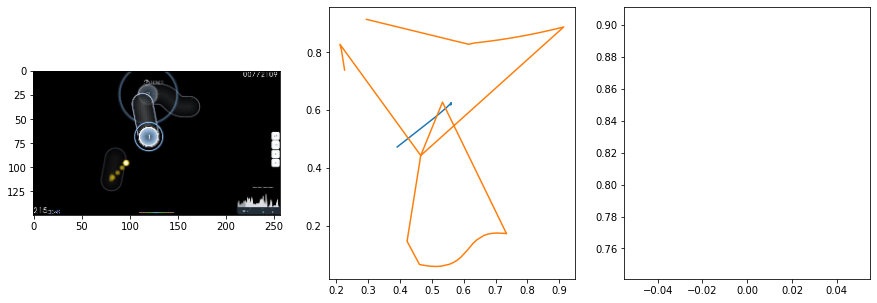

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.15it/s  0.4440                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

1 of 24
pred: 0.23605796694755554 0.4448189437389374
gt: 0.3671875 0.5
(104, 76)


<Figure size 1080x360 with 0 Axes>

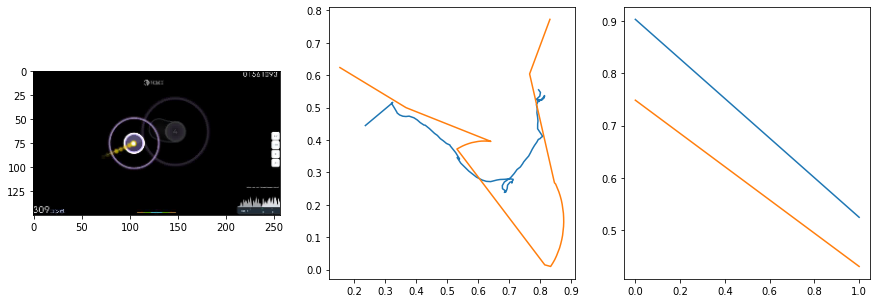

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.12it/s  0.5693                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

2 of 24
pred: 0.26708632707595825 0.22752997279167175
gt: 0.47670719027519226 0.17457562685012817
(121, 38)


<Figure size 1080x360 with 0 Axes>

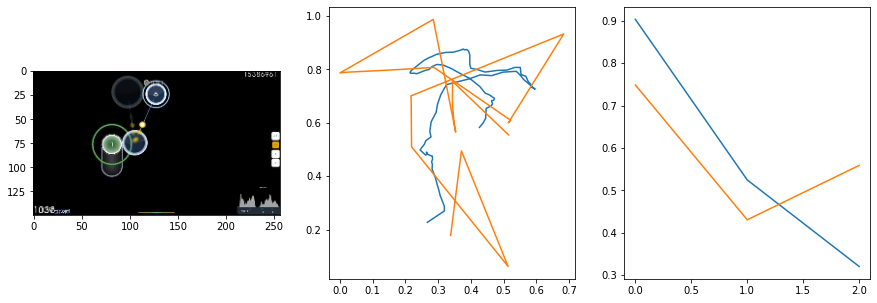

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.09it/s  0.2582                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

3 of 24
pred: 0.43477967381477356 0.40762859582901
gt: 0.7265625 0.40961024165153503
(160, 65)


<Figure size 1080x360 with 0 Axes>

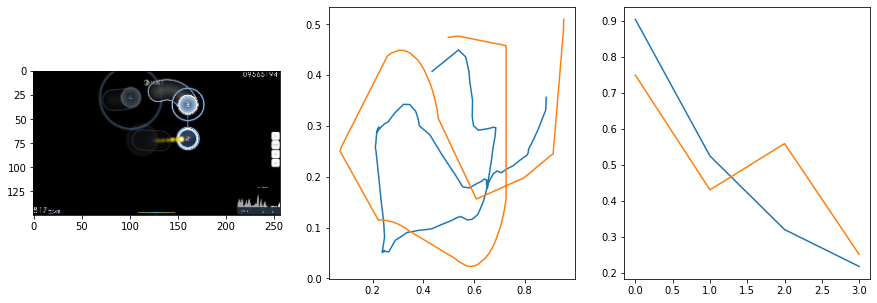

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.09it/s  0.1035                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

4 of 24
pred: 0.45327067375183105 0.2184484601020813
gt: 0.546875 0.40173304080963135
(132, 64)


<Figure size 1080x360 with 0 Axes>

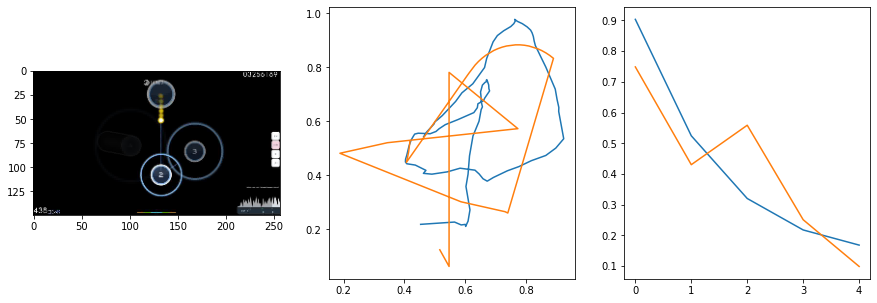

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.08it/s  0.0035                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

5 of 24
pred: 0.5857361555099487 0.22640416026115417
gt: 0.6484375 0.75
(148, 105)


<Figure size 1080x360 with 0 Axes>

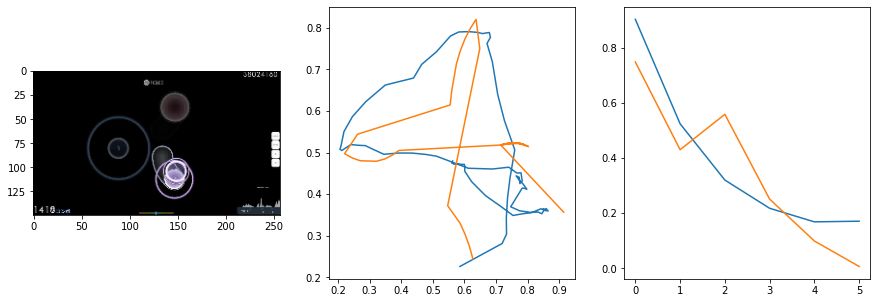

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.08it/s  0.1258                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

6 of 24
pred: 0.4302397668361664 0.5193988680839539
gt: 0.720703125 0.6484375
(159, 93)


<Figure size 1080x360 with 0 Axes>

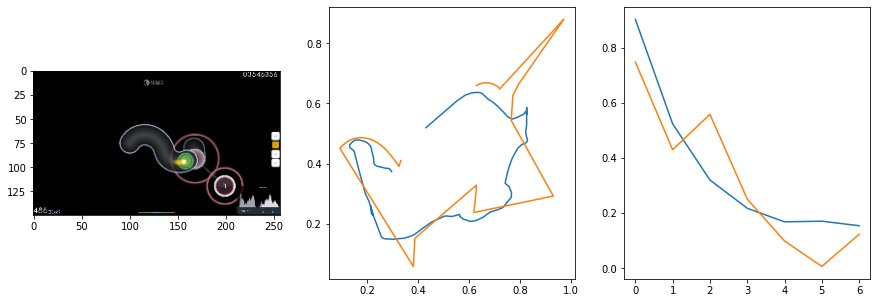

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.03it/s  0.1346                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

7 of 24
pred: 0.5333221554756165 0.1807451844215393
gt: 0.6286606192588806 0.12493985891342163
(145, 32)


<Figure size 1080x360 with 0 Axes>

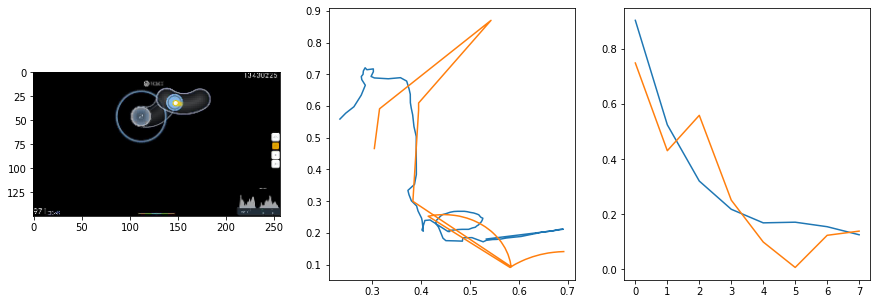

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.04it/s  0.2063                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

8 of 24
pred: 0.4144507646560669 0.2518177628517151
gt: 0.5780979990959167 0.5066275596618652
(137, 76)


<Figure size 1080x360 with 0 Axes>

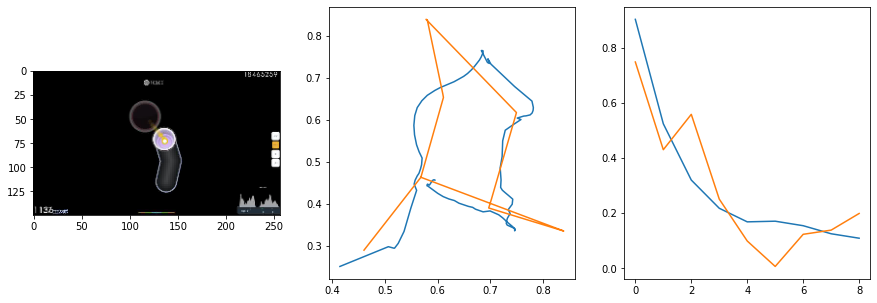

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.06it/s  0.1494                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

9 of 24
pred: 0.3879050016403198 0.6853845715522766
gt: 0.41807466745376587 0.6017037034034729
(112, 87)


<Figure size 1080x360 with 0 Axes>

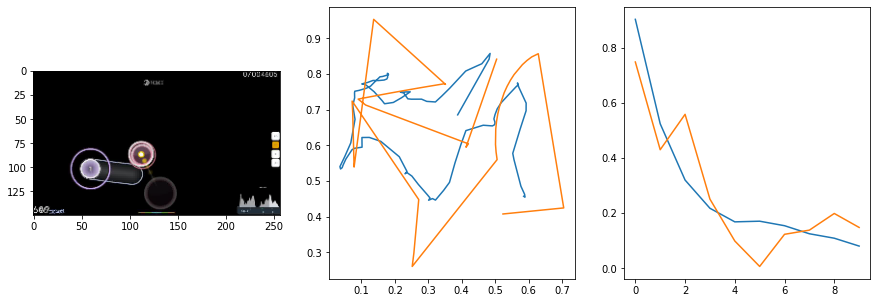

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.07it/s  0.0785                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

10 of 24
pred: 0.3274695873260498 0.374312162399292
gt: 0.47187501192092896 0.5625
(121, 83)


<Figure size 1080x360 with 0 Axes>

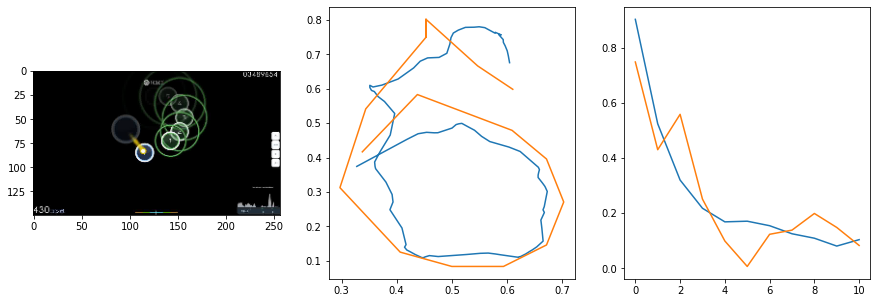

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.06it/s  0.0346                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

11 of 24
pred: 0.6209222078323364 0.681056797504425
gt: 0.9074938893318176 0.5932753682136536
(188, 87)


<Figure size 1080x360 with 0 Axes>

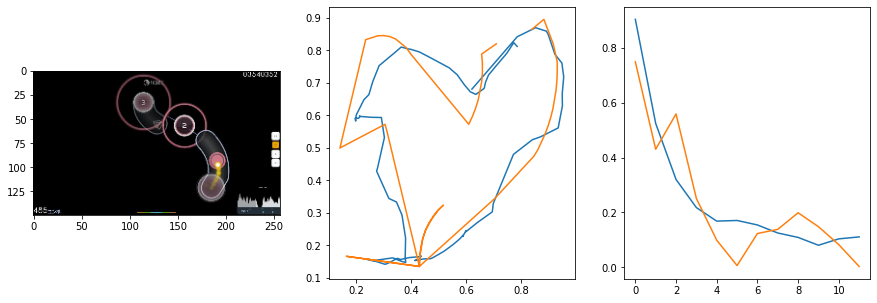

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.08it/s  0.0170                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

12 of 24
pred: 0.31634217500686646 0.39600133895874023
gt: 0.4228510558605194 0.40931692719459534
(113, 65)


<Figure size 1080x360 with 0 Axes>

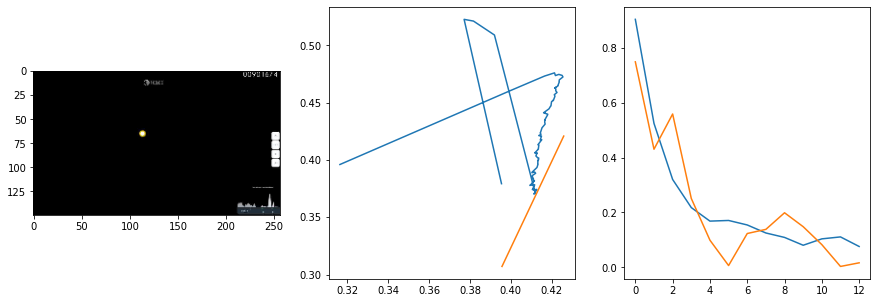

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.08it/s  0.0035                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

13 of 24
pred: 0.35660335421562195 0.24973440170288086
gt: 0.3692753314971924 0.2934626340866089
(105, 52)


<Figure size 1080x360 with 0 Axes>

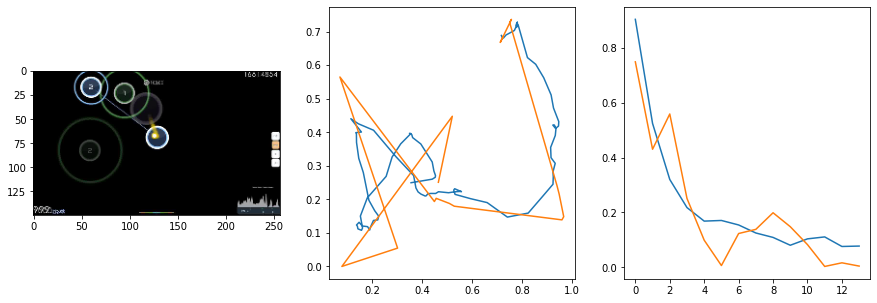

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  5.99it/s  0.0247                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

14 of 24
pred: 0.6298889517784119 0.37194228172302246
gt: 0.91390460729599 0.2810734212398529
(189, 50)


<Figure size 1080x360 with 0 Axes>

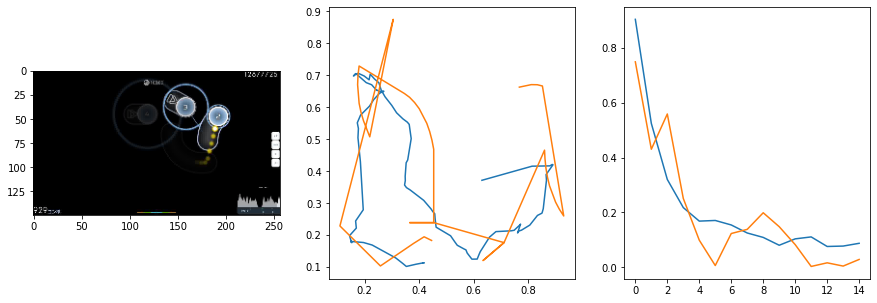

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.06it/s  0.1815                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

15 of 24
pred: 0.3715243637561798 0.48276594281196594
gt: 0.6601046323776245 0.6053743958473206
(150, 88)


<Figure size 1080x360 with 0 Axes>

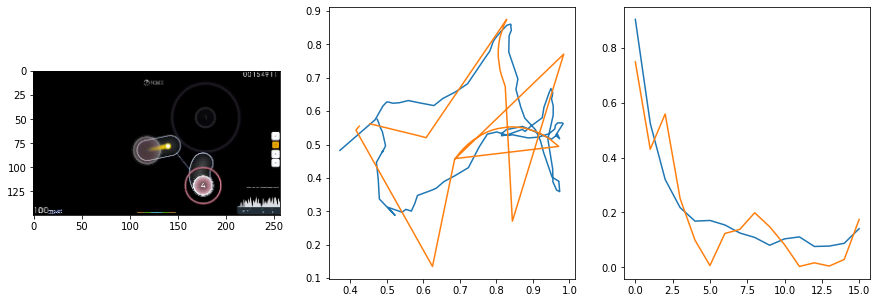

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.08it/s  0.1422                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

16 of 24
pred: 0.47091221809387207 0.5464544296264648
gt: 0.5264420509338379 0.9519227147102356
(129, 128)


<Figure size 1080x360 with 0 Axes>

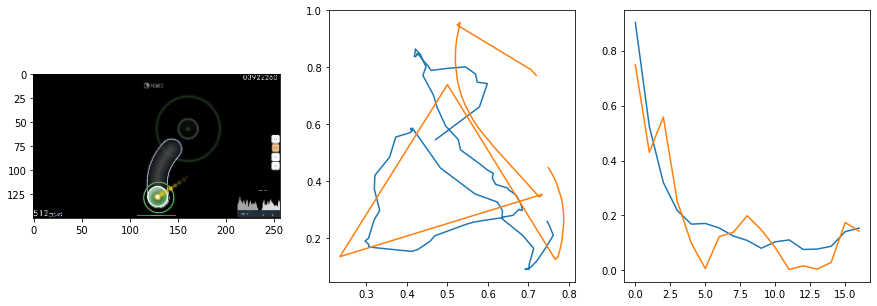

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.04it/s  0.0031                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

17 of 24
pred: 0.6266553401947021 0.18515527248382568
gt: 0.7408084869384766 0.09191128611564636
(162, 28)


<Figure size 1080x360 with 0 Axes>

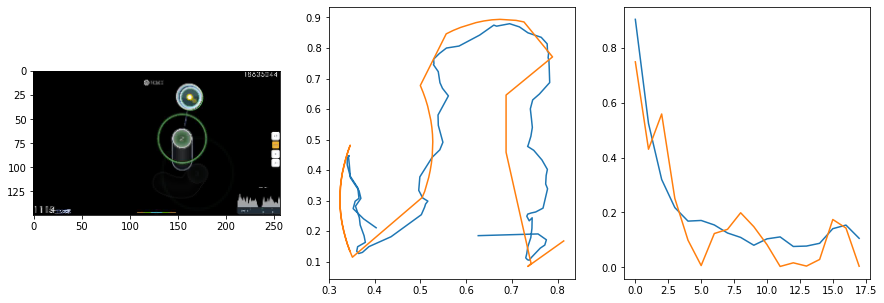

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.06it/s  0.0556                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

18 of 24
pred: 0.5513367652893066 0.7523378133773804
gt: 0.4765625 0.7916666865348816
(121, 110)


<Figure size 1080x360 with 0 Axes>

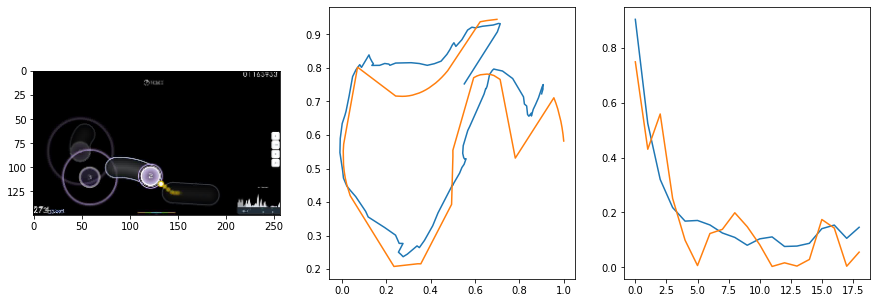

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.05it/s  0.0076                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

19 of 24
pred: 0.2971217632293701 0.41101089119911194
gt: 0.42558810114860535 0.8279717564582825
(113, 114)


<Figure size 1080x360 with 0 Axes>

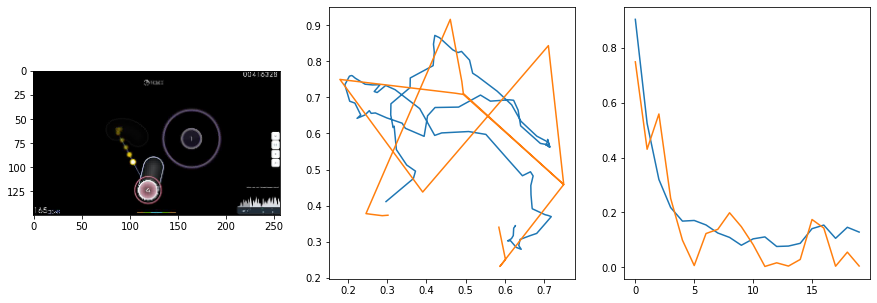

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.06it/s  0.3182                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

20 of 24
pred: 0.4798741340637207 0.34040209650993347
gt: 0.5147569179534912 0.5188078880310059
(127, 78)


<Figure size 1080x360 with 0 Axes>

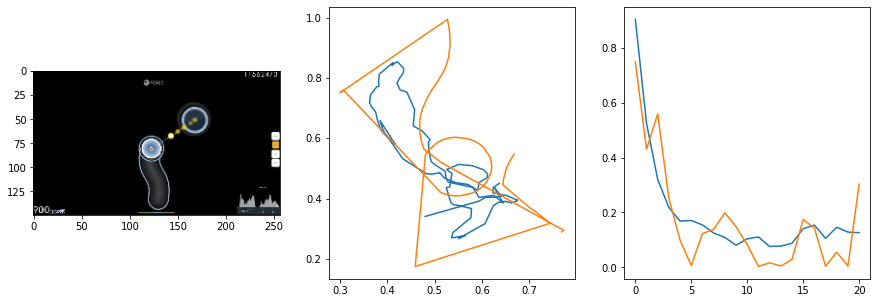

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.06it/s  0.0622                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

21 of 24
pred: 0.25083595514297485 0.7601065039634705
gt: 0.15104961395263672 0.8755345940589905
(71, 119)


<Figure size 1080x360 with 0 Axes>

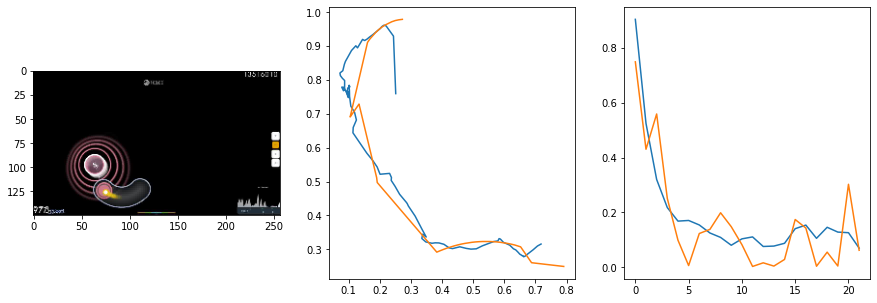

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  5.96it/s  0.0640                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

22 of 24
pred: 0.3538123071193695 0.39201849699020386
gt: 0.4786164462566376 0.48574432730674744
(122, 74)


<Figure size 1080x360 with 0 Axes>

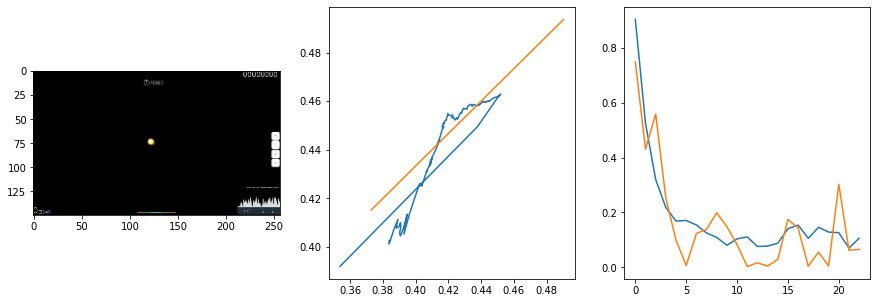

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.05it/s  0.1224                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

23 of 24
pred: 0.37660565972328186 0.37696537375450134
gt: 0.4386558532714844 0.4268336594104767
(116, 67)


<Figure size 1080x360 with 0 Axes>

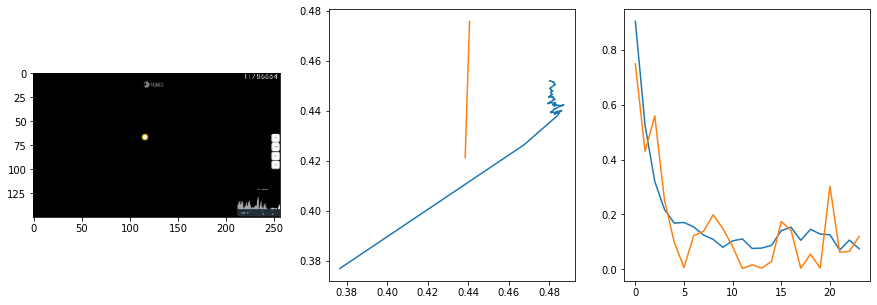

133.52324795722961 secs


In [18]:
start = time.time()

epochs = 24
lamb = 0.5
trainVN()

end = time.time()
print(end - start, 'secs')

In [19]:
#criterion = nn.L1Loss()
optimizer = torch.optim.Adam(vn.parameters(), lr=0.001)

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.00it/s  0.0548                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

24 of 88
pred: 0.45628365874290466 0.385841965675354
gt: 0.6853125095367432 0.34583333134651184
(154, 58)


<Figure size 1080x360 with 0 Axes>

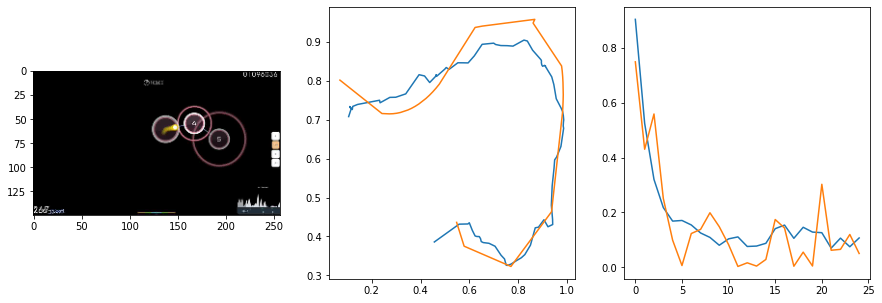

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.08it/s  0.1006                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

25 of 88
pred: 0.37174132466316223 0.5357316732406616
gt: 0.46875 0.40816664695739746
(120, 65)


<Figure size 1080x360 with 0 Axes>

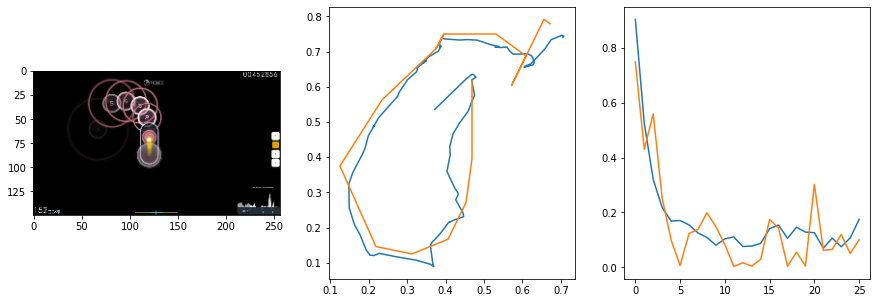

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.08it/s  0.0879                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

26 of 88
pred: 0.45172256231307983 0.3745834529399872
gt: 0.49900132417678833 0.8572092652320862
(125, 117)


<Figure size 1080x360 with 0 Axes>

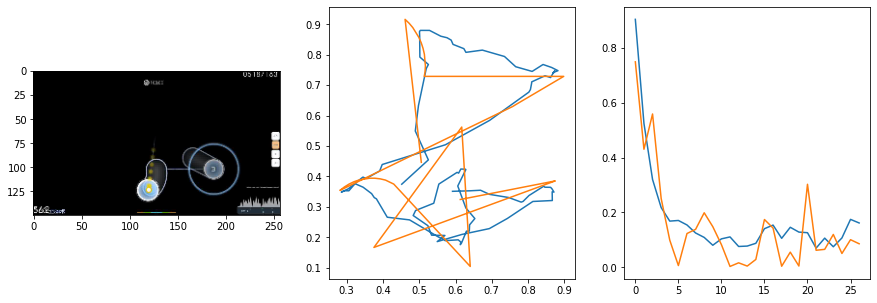

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.04it/s  0.6148                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

27 of 88
pred: 0.08774325251579285 0.4678826332092285
gt: 0.15567974746227264 0.6374125480651855
(72, 92)


<Figure size 1080x360 with 0 Axes>

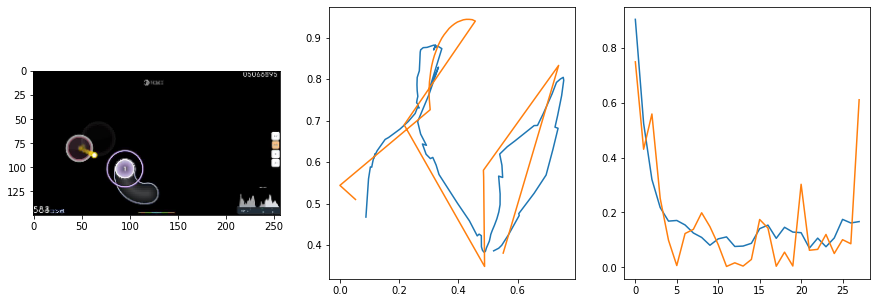

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.08it/s  0.0855                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

28 of 88
pred: 0.505734384059906 0.38120657205581665
gt: 0.484375 0.2916666567325592
(123, 51)


<Figure size 1080x360 with 0 Axes>

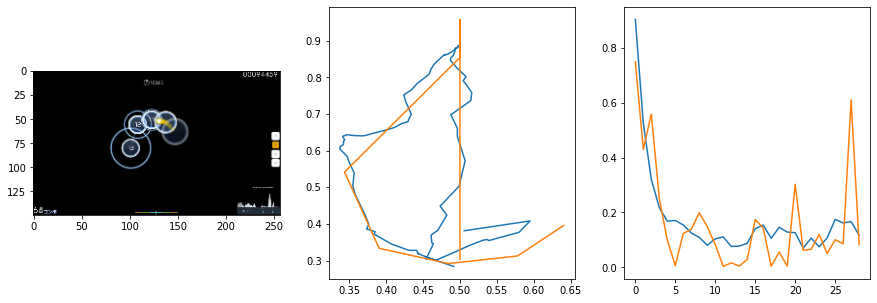

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.05it/s  0.0697                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

29 of 88
pred: 0.6606451869010925 0.21611839532852173
gt: 0.84375 0.65625
(178, 94)


<Figure size 1080x360 with 0 Axes>

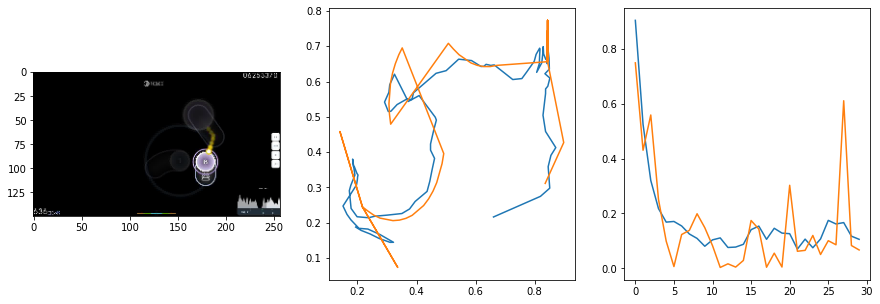

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.07it/s  0.2411                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

30 of 88
pred: 0.4307518005371094 0.5027908086776733
gt: 0.791796863079071 0.7718749642372131
(170, 107)


<Figure size 1080x360 with 0 Axes>

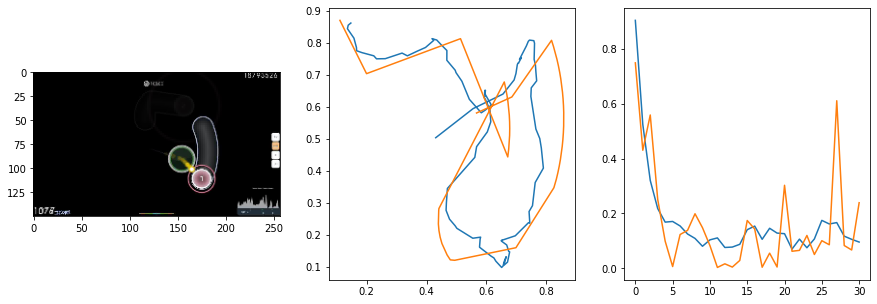

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.02it/s  0.0352                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

31 of 88
pred: 0.6237830519676208 0.07049354910850525
gt: 0.8359375 0.0625
(177, 25)


<Figure size 1080x360 with 0 Axes>

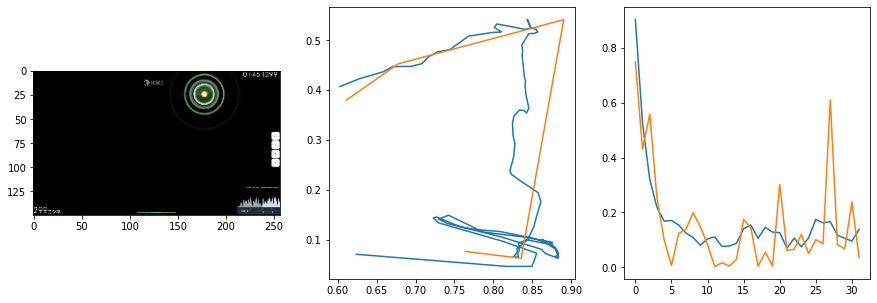

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.06it/s  0.0294                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

32 of 88
pred: 0.12829698622226715 0.3460649847984314
gt: 0.1996859610080719 0.5497525334358215
(78, 81)


<Figure size 1080x360 with 0 Axes>

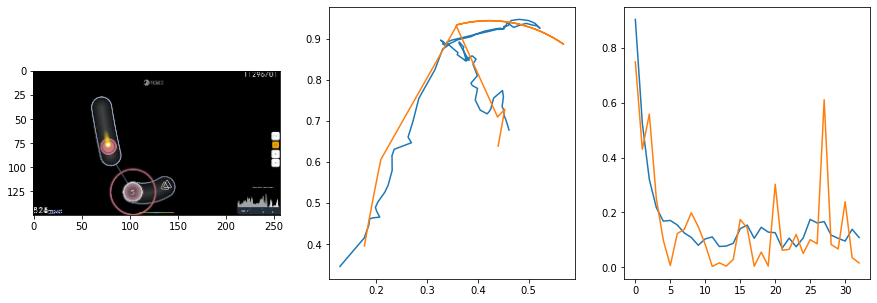

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.05it/s  0.1664                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

33 of 88
pred: 0.11473458260297775 0.19065913558006287
gt: 0.4350709021091461 0.5643764734268188
(115, 83)


<Figure size 1080x360 with 0 Axes>

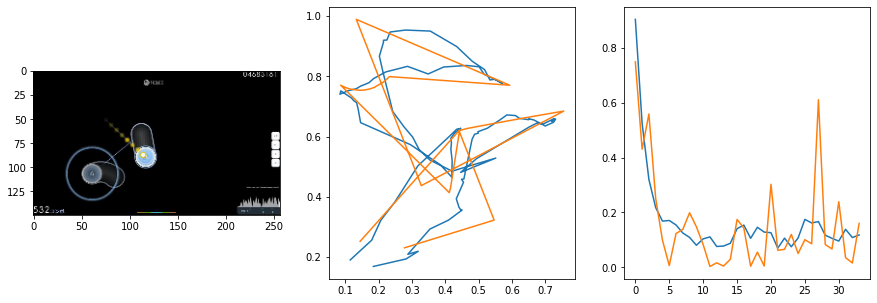

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.05it/s  0.0585                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

34 of 88
pred: 0.5291721820831299 0.6589381694793701
gt: 0.5515413284301758 0.7749672532081604
(133, 108)


<Figure size 1080x360 with 0 Axes>

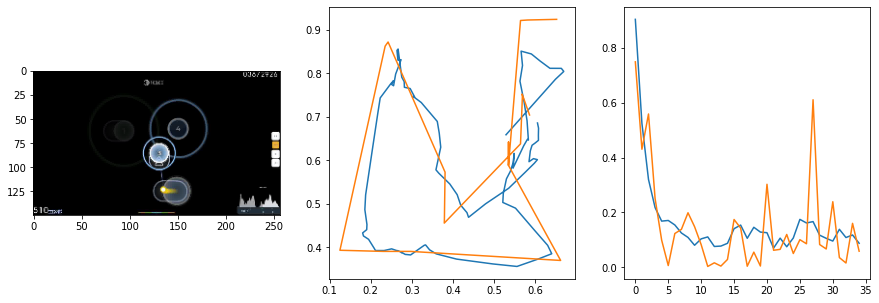

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.06it/s  0.0267                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

35 of 88
pred: 0.6157640218734741 0.26724493503570557
gt: 0.8794825673103333 0.44403788447380066
(184, 69)


<Figure size 1080x360 with 0 Axes>

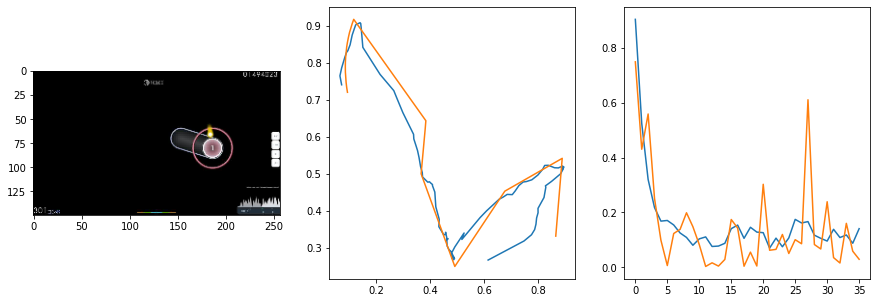

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.05it/s  0.0762                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

36 of 88
pred: 0.4033036530017853 0.4510209262371063
gt: 0.5 0.7613332867622375
(125, 106)


<Figure size 1080x360 with 0 Axes>

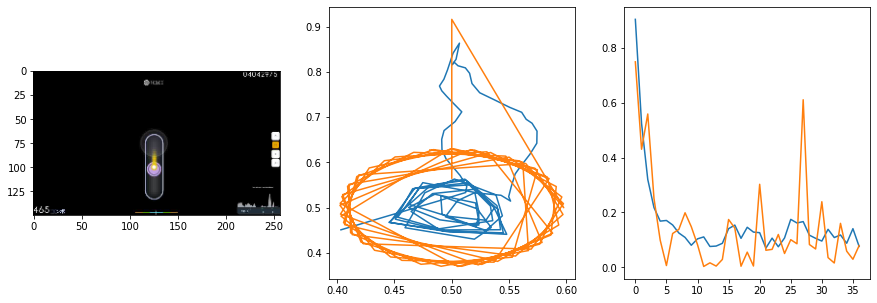

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.03it/s  0.0093                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

37 of 88
pred: 0.2714214622974396 0.3478734791278839
gt: 0.20973068475723267 0.3060636818408966
(80, 53)


<Figure size 1080x360 with 0 Axes>

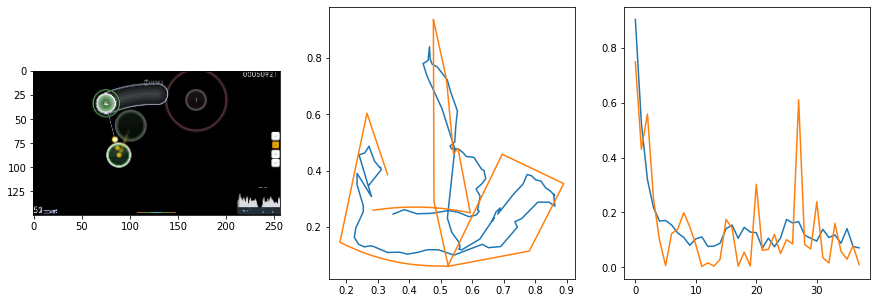

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.06it/s  0.1385                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

38 of 88
pred: 0.5659123659133911 0.635775089263916
gt: 0.6228598356246948 0.741513192653656
(144, 104)


<Figure size 1080x360 with 0 Axes>

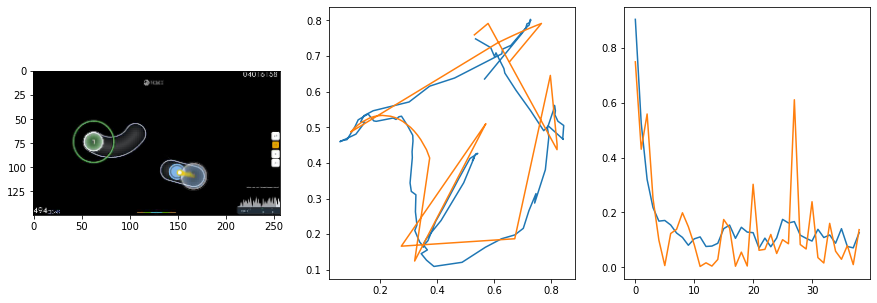

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.02it/s  0.1609                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

39 of 88
pred: 0.6847352385520935 0.42182761430740356
gt: 0.5990081429481506 0.463904470205307
(140, 71)


<Figure size 1080x360 with 0 Axes>

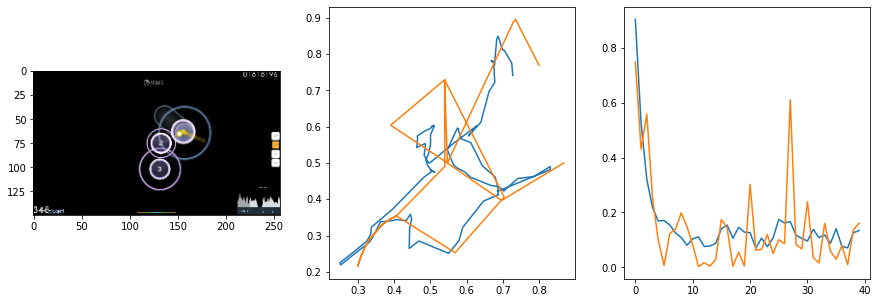

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.05it/s  0.0912                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

40 of 88
pred: 0.44916000962257385 0.46348583698272705
gt: 0.8080089688301086 0.8577220439910889
(173, 117)


<Figure size 1080x360 with 0 Axes>

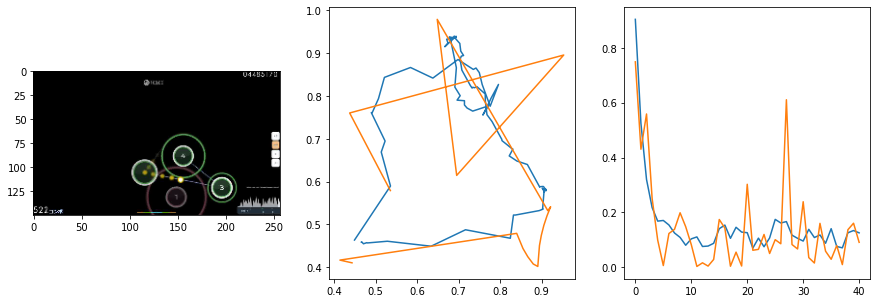

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.03it/s  0.1640                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

41 of 88
pred: 0.6277081966400146 0.16179534792900085
gt: 0.6692751049995422 0.538453996181488
(151, 80)


<Figure size 1080x360 with 0 Axes>

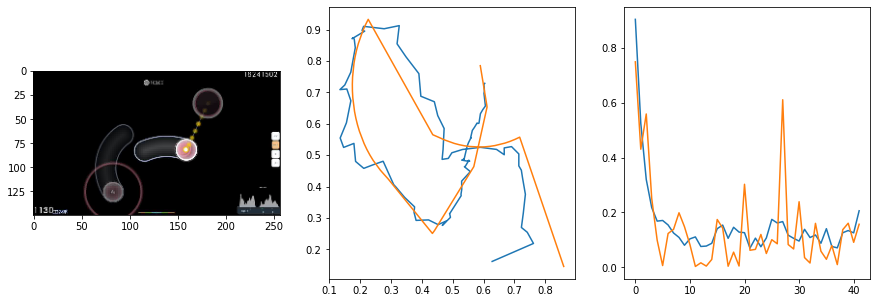

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.05it/s  0.0060                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

42 of 88
pred: 0.2778300940990448 0.7269948124885559
gt: 0.5183458924293518 0.9622126221656799
(128, 129)


<Figure size 1080x360 with 0 Axes>

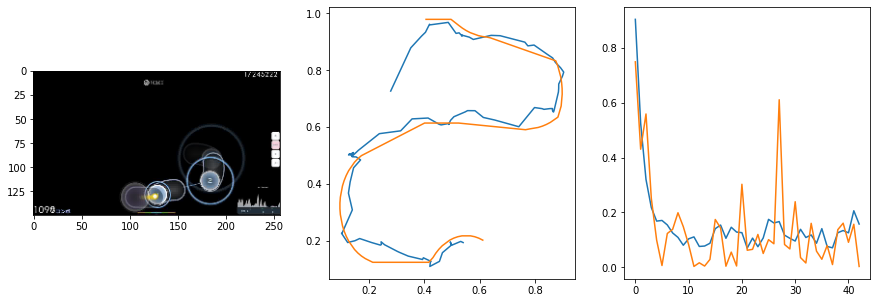

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.06it/s  0.0751                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

43 of 88
pred: 0.39091944694519043 0.2356504499912262
gt: 0.3596290647983551 0.12999661266803741
(103, 33)


<Figure size 1080x360 with 0 Axes>

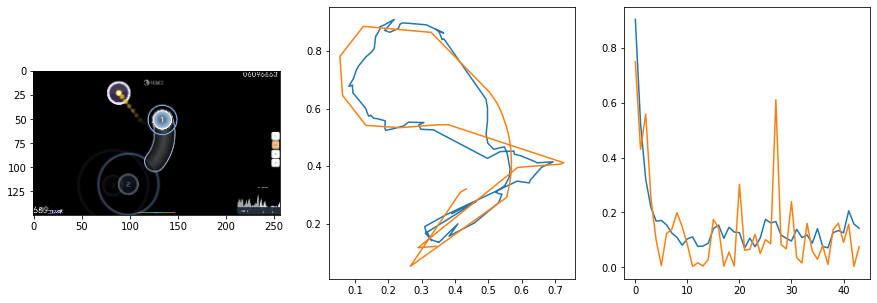

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.06it/s  0.3919                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

44 of 88
pred: 0.40961048007011414 0.4198108911514282
gt: 0.5587192177772522 0.6546921730041504
(134, 94)


<Figure size 1080x360 with 0 Axes>

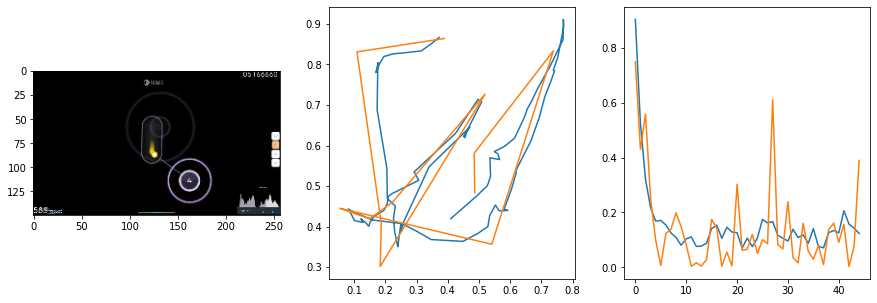

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.04it/s  0.3351                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

45 of 88
pred: 0.33849260210990906 0.6212316751480103
gt: 0.33074596524238586 0.520430326461792
(99, 78)


<Figure size 1080x360 with 0 Axes>

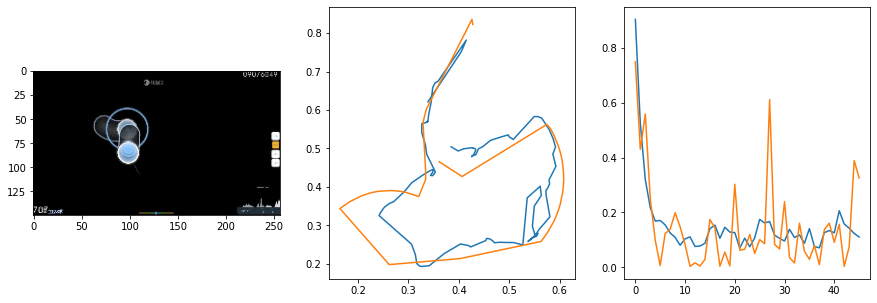

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.05it/s  0.0175                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

46 of 88
pred: 0.2071559876203537 0.4691457152366638
gt: 0.33913668990135193 0.47627925872802734
(100, 73)


<Figure size 1080x360 with 0 Axes>

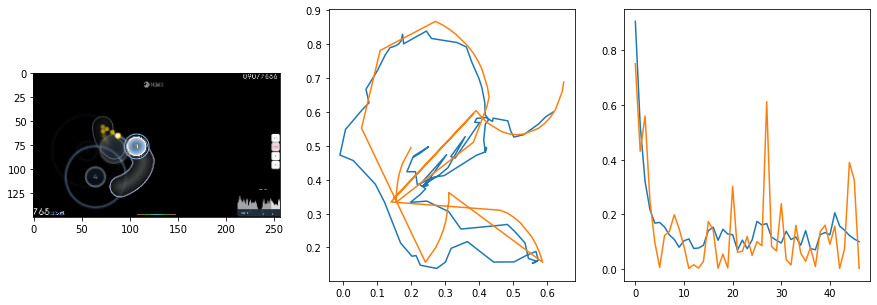

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.05it/s  0.0853                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

47 of 88
pred: 0.5807320475578308 0.39660605788230896
gt: 0.513229250907898 0.24680347740650177
(127, 46)


<Figure size 1080x360 with 0 Axes>

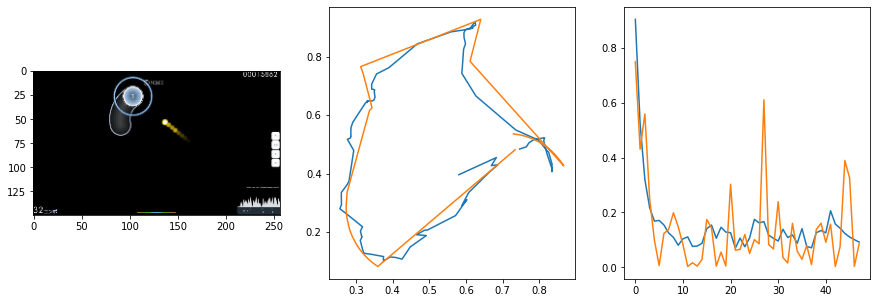

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.03it/s  0.1087                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

48 of 88
pred: 0.42551735043525696 0.5688174962997437
gt: 0.809729814529419 0.9012004733085632
(173, 122)


<Figure size 1080x360 with 0 Axes>

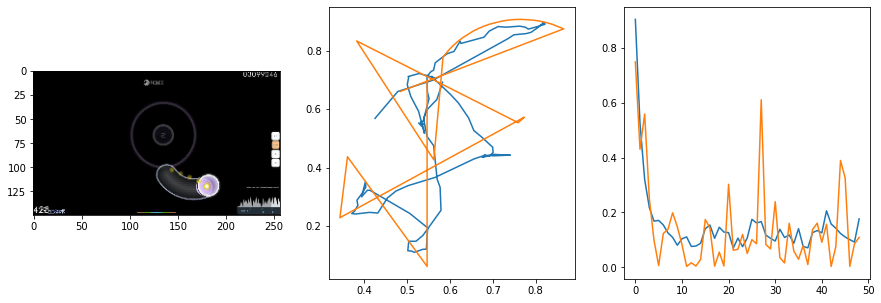

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.04it/s  0.1135                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

49 of 88
pred: 0.33638736605644226 0.541822075843811
gt: 0.3624805808067322 0.6376656889915466
(104, 92)


<Figure size 1080x360 with 0 Axes>

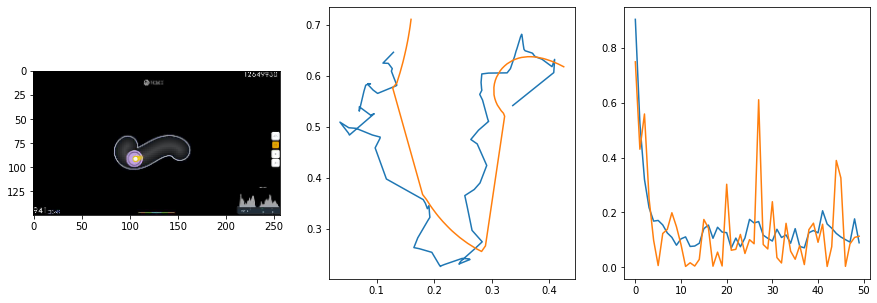

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.03it/s  0.8988                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

50 of 88
pred: 0.19029919803142548 0.44276368618011475
gt: 0.18570950627326965 0.5634157657623291
(76, 83)


<Figure size 1080x360 with 0 Axes>

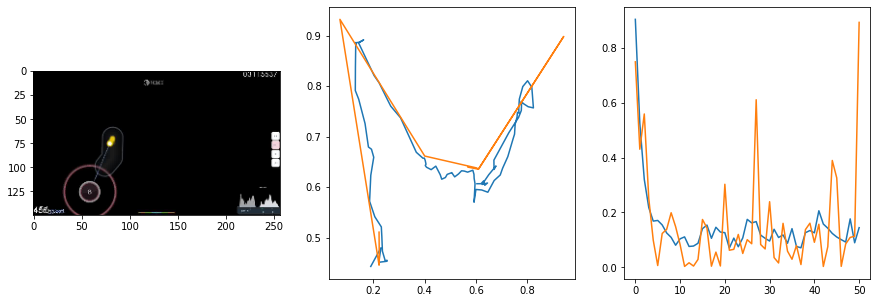

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.02it/s  0.0093                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

51 of 88
pred: 0.1436842381954193 0.44602227210998535
gt: 0.1583460420370102 0.48699188232421875
(72, 74)


<Figure size 1080x360 with 0 Axes>

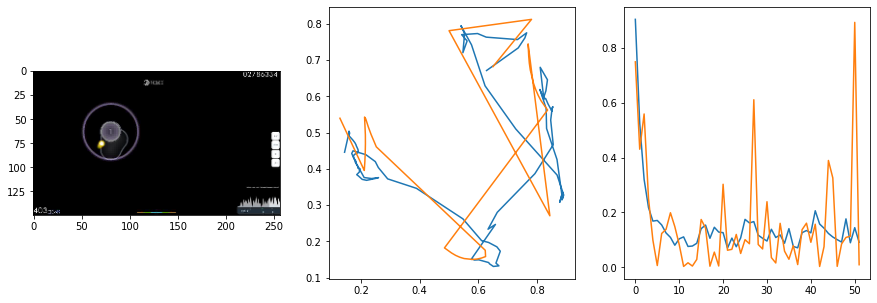

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.03it/s  0.0441                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

52 of 88
pred: 0.32977575063705444 0.4489503502845764
gt: 0.4442499876022339 0.5
(116, 76)


<Figure size 1080x360 with 0 Axes>

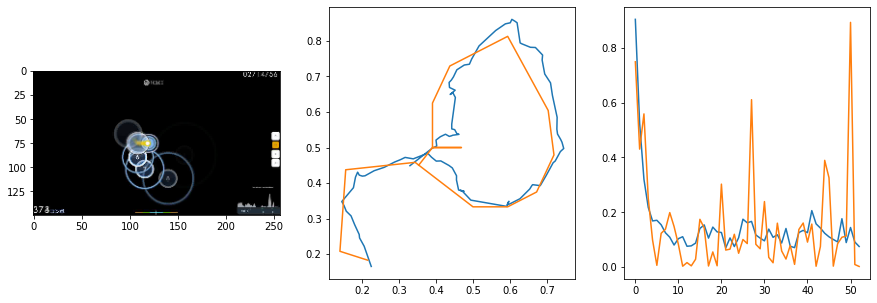

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  5.99it/s  0.0781                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

53 of 88
pred: 0.2846406400203705 0.5021181106567383
gt: 0.29857271909713745 0.876962423324585
(94, 119)


<Figure size 1080x360 with 0 Axes>

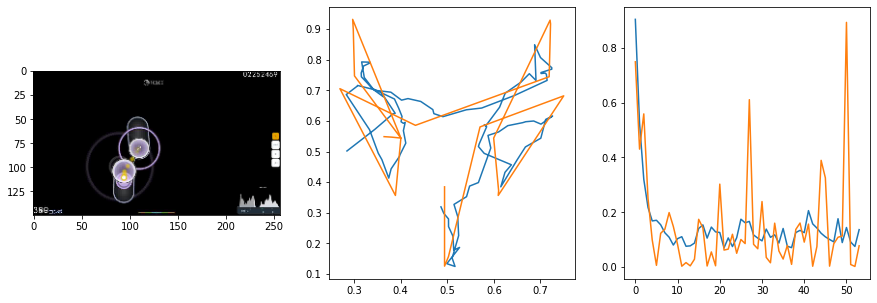

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.05it/s  0.0647                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

54 of 88
pred: 0.5962506532669067 0.6771059632301331
gt: 0.514668345451355 0.7117347121238708
(127, 100)


<Figure size 1080x360 with 0 Axes>

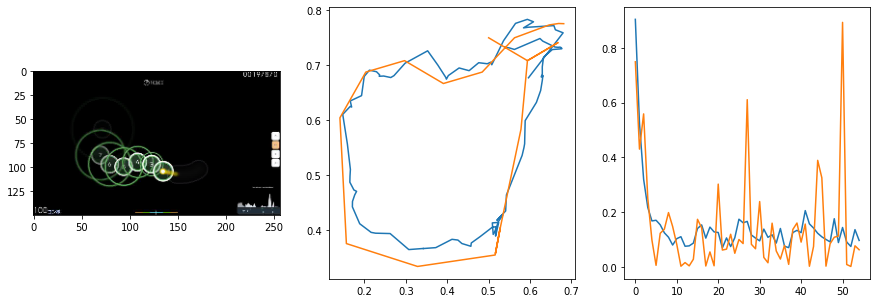

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.05it/s  0.1002                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

55 of 88
pred: 0.2703947424888611 0.3269287943840027
gt: 0.44641348719596863 0.2415419965982437
(117, 46)


<Figure size 1080x360 with 0 Axes>

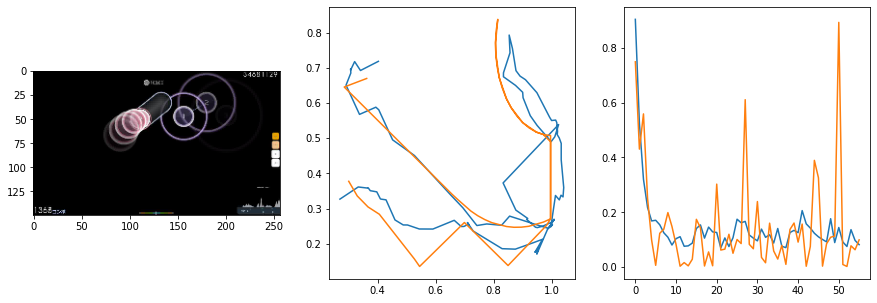

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.01it/s  0.0519                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

56 of 88
pred: 0.7162261605262756 0.4400409460067749
gt: 0.9128808975219727 0.5201855301856995
(189, 78)


<Figure size 1080x360 with 0 Axes>

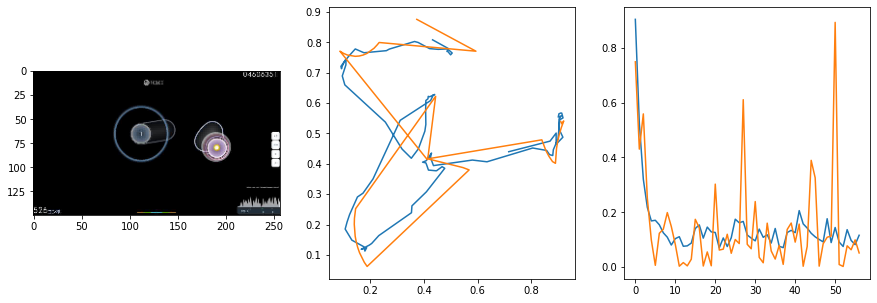

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  5.99it/s  0.0429                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

57 of 88
pred: 0.3733997642993927 0.6674798727035522
gt: 0.5 0.8541666865348816
(125, 117)


<Figure size 1080x360 with 0 Axes>

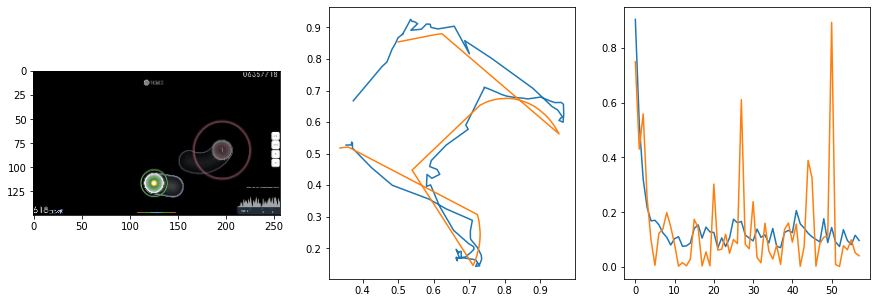

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.00it/s  0.0539                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

58 of 88
pred: 0.0675361156463623 0.615038275718689
gt: 0.2255898267030716 0.526113748550415
(82, 79)


<Figure size 1080x360 with 0 Axes>

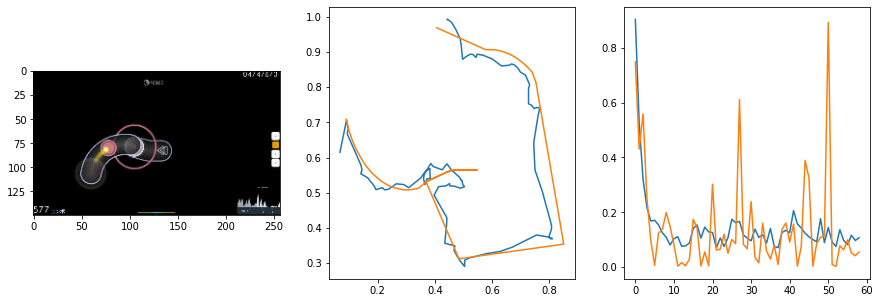

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.06it/s  0.0140                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

59 of 88
pred: 0.6832762956619263 0.5685099363327026
gt: 0.9499691724777222 0.7656860947608948
(195, 107)


<Figure size 1080x360 with 0 Axes>

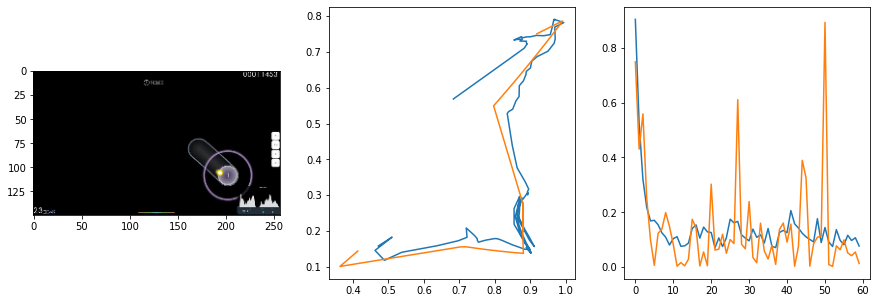

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.05it/s  0.0399                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

60 of 88
pred: 0.17126381397247314 0.6206654906272888
gt: 0.10920904576778412 0.7413364052772522
(64, 104)


<Figure size 1080x360 with 0 Axes>

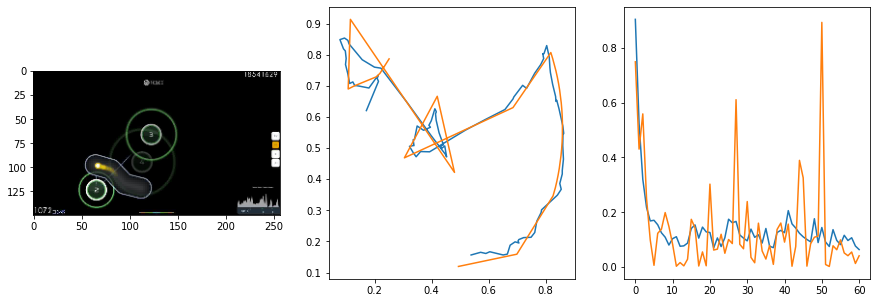

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.04it/s  0.0550                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

61 of 88
pred: 0.40889716148376465 0.08782100677490234
gt: 0.36250001192092896 0.20000000298023224
(104, 41)


<Figure size 1080x360 with 0 Axes>

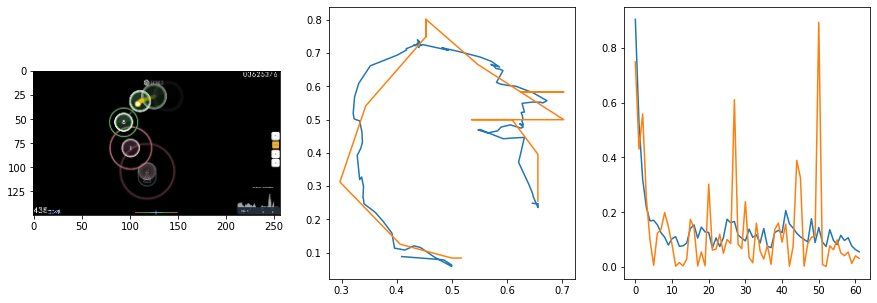

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.02it/s  0.0967                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

62 of 88
pred: 0.5299283862113953 0.6136250495910645
gt: 0.75 0.9479166865348816
(164, 128)


<Figure size 1080x360 with 0 Axes>

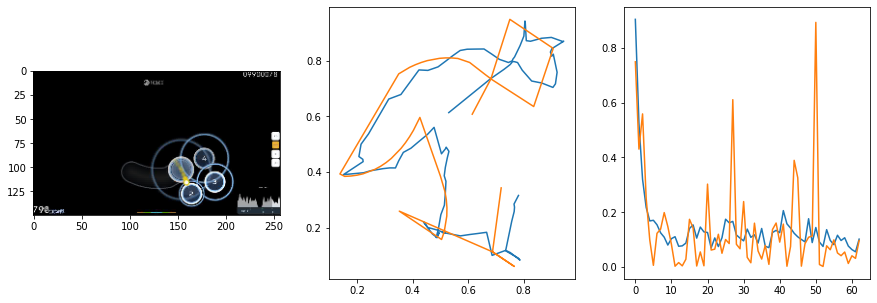

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.02it/s  0.0183                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

63 of 88
pred: 0.7327284216880798 0.26046422123908997
gt: 0.765625 0.6041666865348816
(166, 88)


<Figure size 1080x360 with 0 Axes>

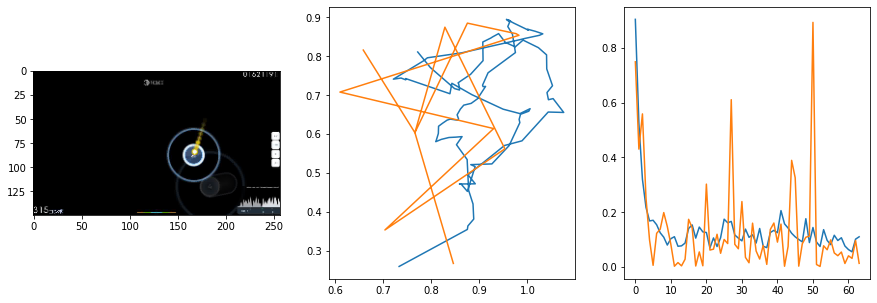

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.01it/s  0.0528                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

64 of 88
pred: 0.41311660408973694 0.449584424495697
gt: 0.40649107098579407 0.46245720982551575
(111, 71)


<Figure size 1080x360 with 0 Axes>

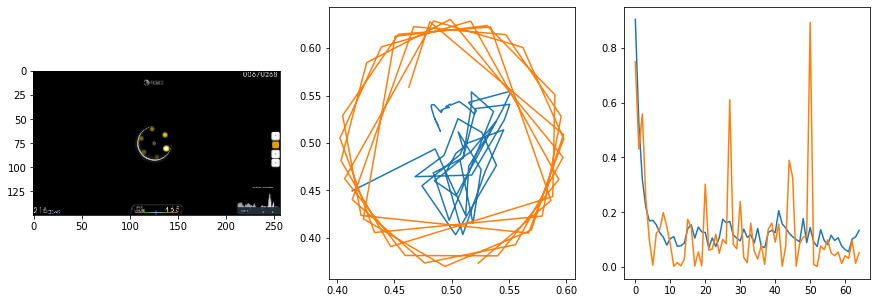

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.02it/s  0.0625                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

65 of 88
pred: 0.7011537551879883 0.12977087497711182
gt: 0.90625 0.328125
(188, 56)


<Figure size 1080x360 with 0 Axes>

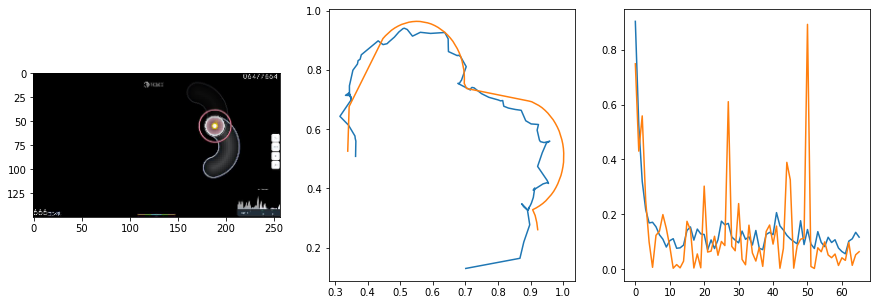

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  5.98it/s  0.7688                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

66 of 88
pred: 0.2793140411376953 0.3237683176994324
gt: 0.3277435898780823 0.3851623833179474
(98, 62)


<Figure size 1080x360 with 0 Axes>

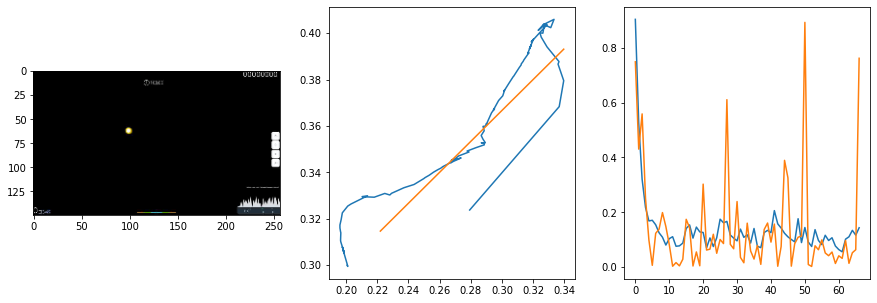

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.00it/s  0.0520                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

67 of 88
pred: 0.620809018611908 0.27573707699775696
gt: 0.9107328653335571 0.6453187465667725
(189, 93)


<Figure size 1080x360 with 0 Axes>

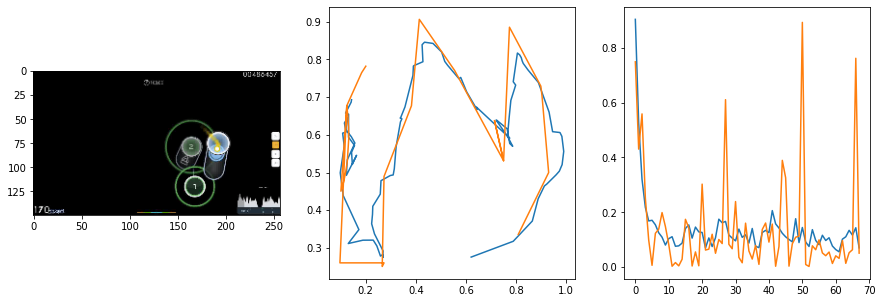

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.01it/s  0.0338                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

68 of 88
pred: 0.6554387807846069 0.14159804582595825
gt: 0.6998199224472046 0.35499951243400574
(156, 59)


<Figure size 1080x360 with 0 Axes>

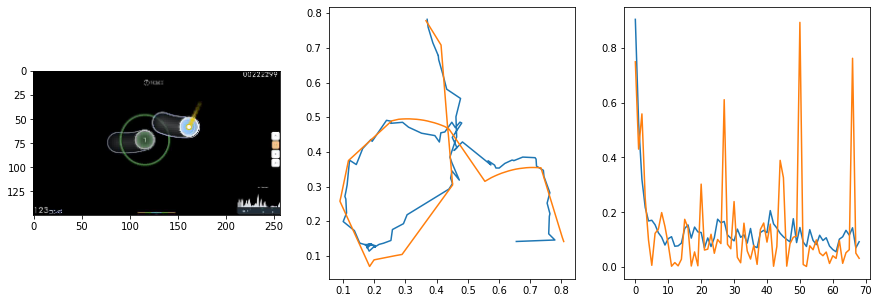

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.03it/s  0.0430                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

69 of 88
pred: 0.27111196517944336 0.607311487197876
gt: 0.25007882714271545 0.8685071468353271
(86, 119)


<Figure size 1080x360 with 0 Axes>

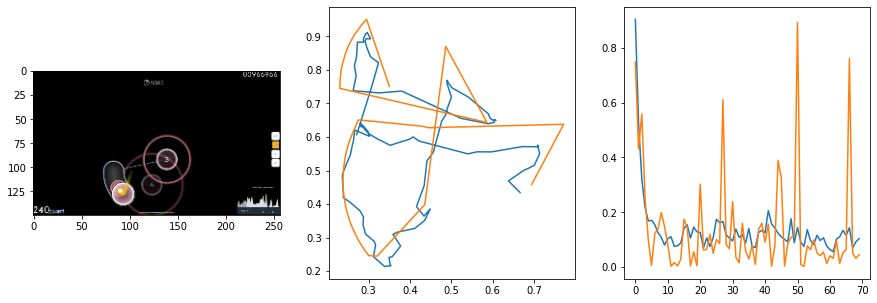

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.06it/s  0.0491                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

70 of 88
pred: 0.3413395881652832 0.2953944206237793
gt: 0.48362329602241516 0.39955613017082214
(122, 64)


<Figure size 1080x360 with 0 Axes>

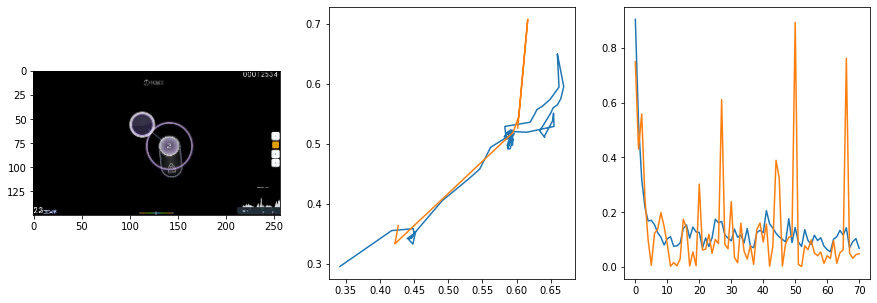

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.04it/s  0.1253                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

71 of 88
pred: 0.5841894149780273 0.258851557970047
gt: 0.859375 0.5625
(181, 83)


<Figure size 1080x360 with 0 Axes>

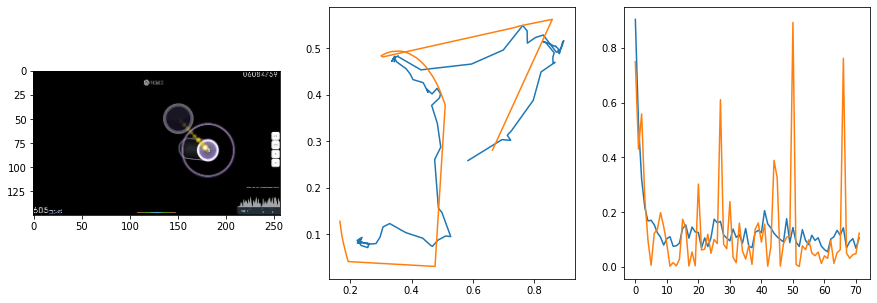

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.04it/s  0.0475                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

72 of 88
pred: 0.3919597864151001 0.5721576809883118
gt: 0.34917083382606506 0.7392097115516663
(102, 103)


<Figure size 1080x360 with 0 Axes>

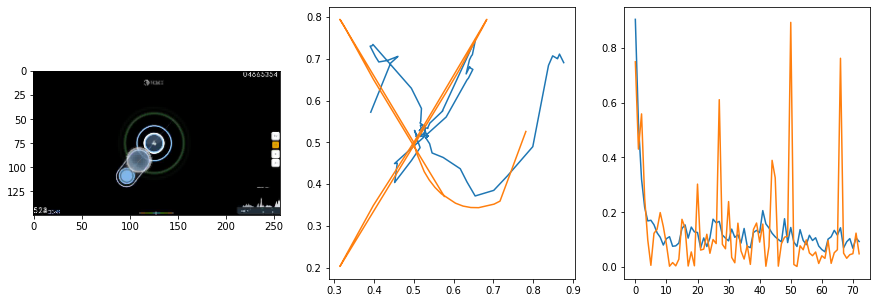

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.05it/s  0.0555                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

73 of 88
pred: 0.7685572504997253 0.6902588605880737
gt: 0.7206548452377319 0.7934982776641846
(159, 110)


<Figure size 1080x360 with 0 Axes>

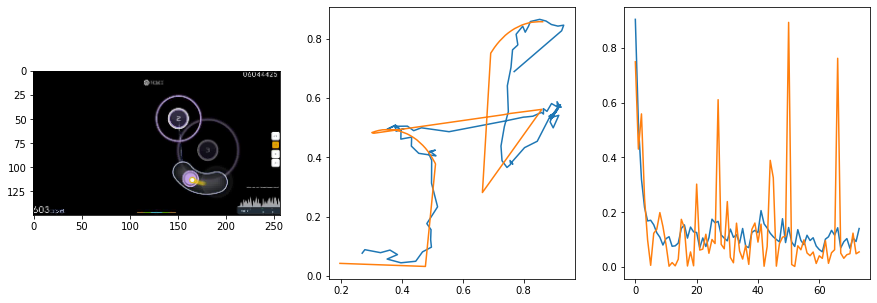

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  5.83it/s  0.0697                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

74 of 88
pred: 0.3299822211265564 0.31823575496673584
gt: 0.5233535766601562 0.489785760641098
(129, 74)


<Figure size 1080x360 with 0 Axes>

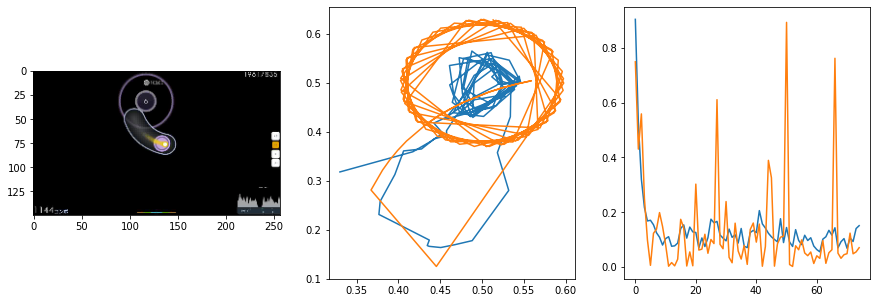

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.02it/s  0.0035                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

75 of 88
pred: 0.080416738986969 0.45869654417037964
gt: 0.17791970074176788 0.6507185101509094
(75, 93)


<Figure size 1080x360 with 0 Axes>

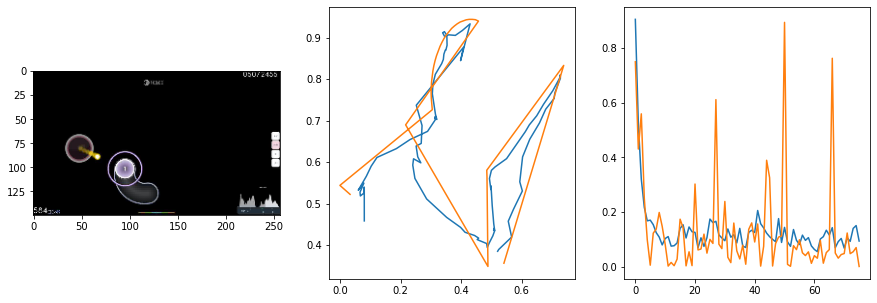

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.05it/s  0.1195                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

76 of 88
pred: 0.6686209440231323 0.2788945734500885
gt: 0.8438012003898621 0.33356010913848877
(178, 56)


<Figure size 1080x360 with 0 Axes>

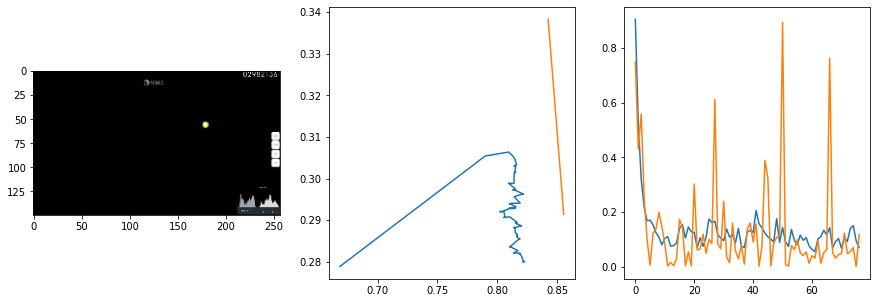

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.04it/s  0.0183                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

77 of 88
pred: 0.6991938352584839 0.21073861420154572
gt: 0.7023354768753052 0.43234744668006897
(156, 68)


<Figure size 1080x360 with 0 Axes>

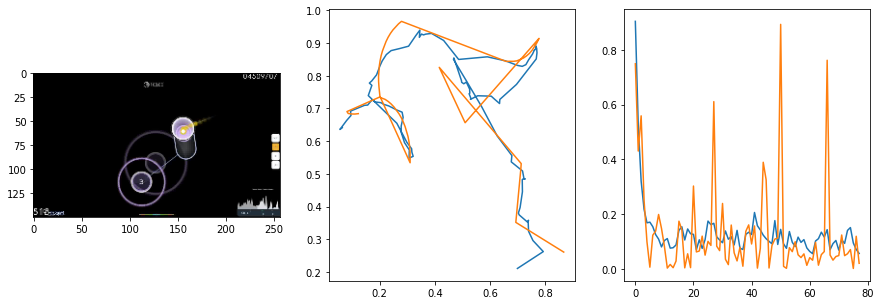

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.01it/s  0.0858                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

78 of 88
pred: 0.206153005361557 0.5635877847671509
gt: 0.1953125 0.8854166865348816
(78, 120)


<Figure size 1080x360 with 0 Axes>

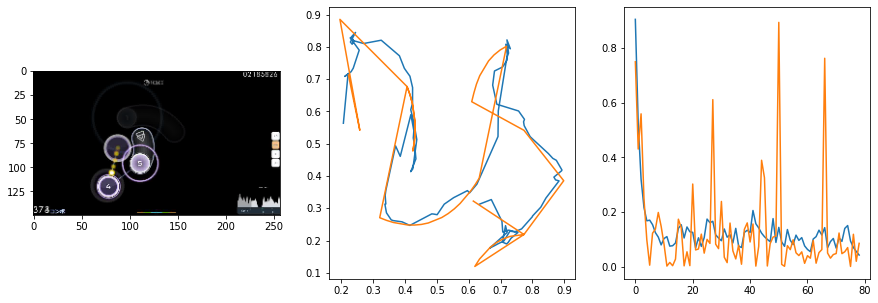

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.05it/s  0.0692                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

79 of 88
pred: 0.7583113312721252 0.5066415071487427
gt: 0.6708640456199646 0.545953631401062
(152, 81)


<Figure size 1080x360 with 0 Axes>

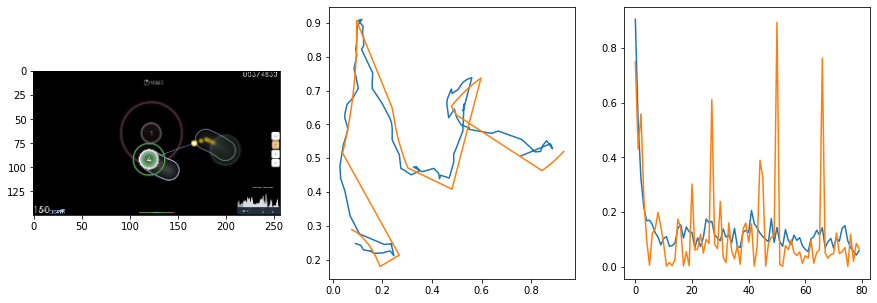

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  5.91it/s  0.1494                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

80 of 88
pred: 0.6294603943824768 0.5775673985481262
gt: 0.7204833626747131 0.6827578544616699
(159, 97)


<Figure size 1080x360 with 0 Axes>

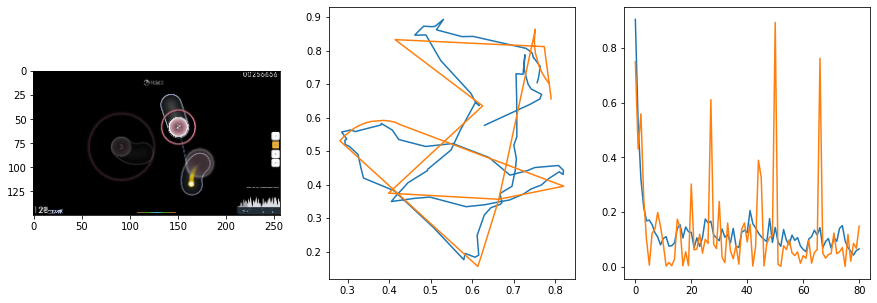

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.04it/s  0.0334                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

81 of 88
pred: 0.1668805330991745 0.5101068019866943
gt: 0.236565962433815 0.6676276326179504
(84, 95)


<Figure size 1080x360 with 0 Axes>

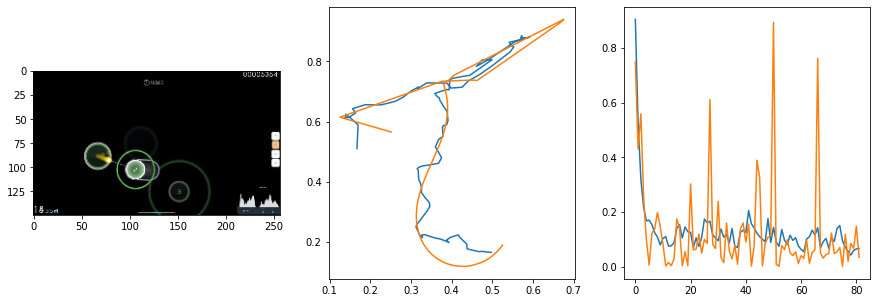

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.05it/s  0.0060                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

82 of 88
pred: 0.5113971829414368 0.6611669063568115
gt: 0.7268750071525574 0.5291666388511658
(160, 79)


<Figure size 1080x360 with 0 Axes>

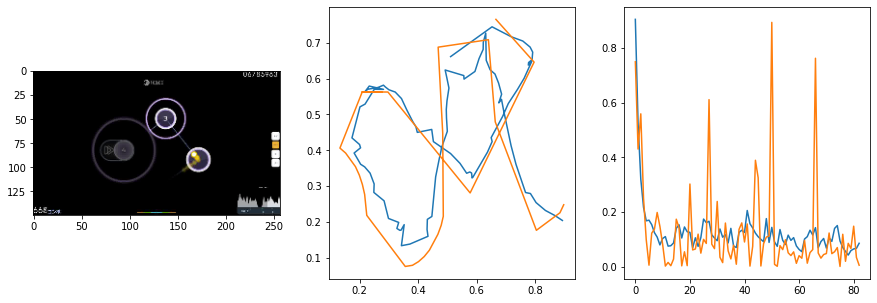

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.04it/s  0.0410                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

83 of 88
pred: 0.16777187585830688 0.5590791702270508
gt: 0.4859375059604645 0.5054166913032532
(123, 76)


<Figure size 1080x360 with 0 Axes>

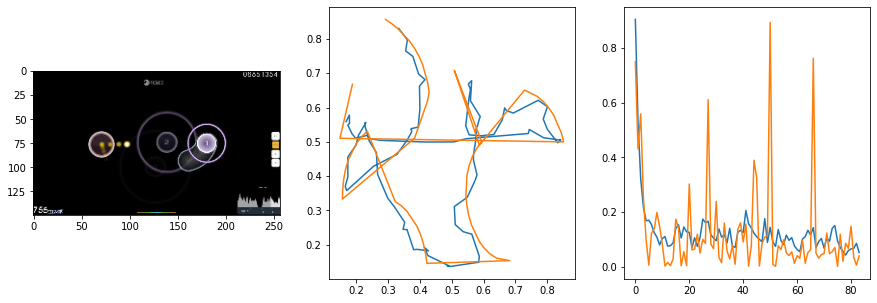

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.01it/s  0.0078                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

84 of 88
pred: 0.5909516215324402 0.4975837171077728
gt: 0.59375 0.6458333134651184
(140, 93)


<Figure size 1080x360 with 0 Axes>

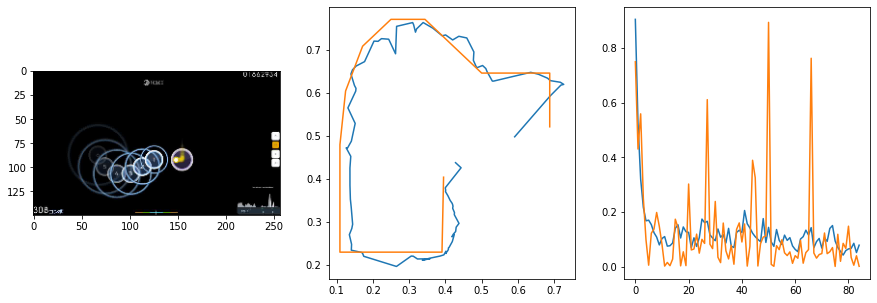

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.03it/s  0.0073                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

85 of 88
pred: 0.3003775179386139 0.6251198649406433
gt: 0.5 0.7205833792686462
(125, 101)


<Figure size 1080x360 with 0 Axes>

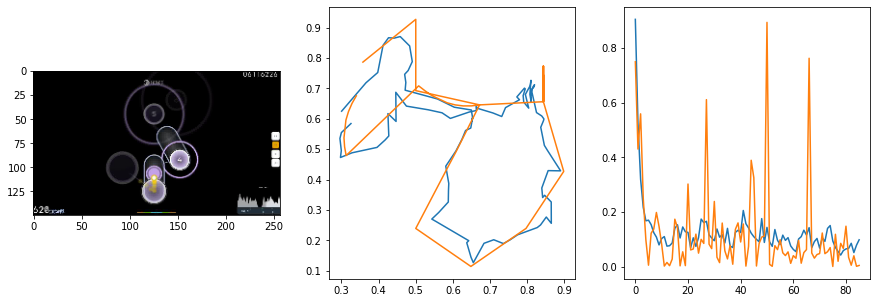

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.03it/s  0.0035                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

86 of 88
pred: 0.32228508591651917 0.46622732281684875
gt: 0.4657675623893738 0.44522809982299805
(120, 69)


<Figure size 1080x360 with 0 Axes>

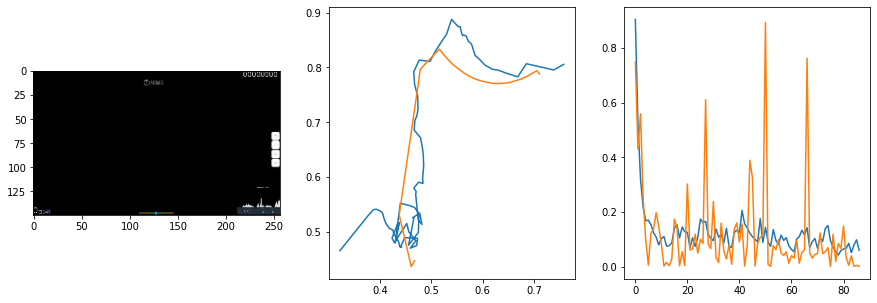

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.03it/s  0.0694                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

87 of 88
pred: 0.6452785134315491 0.7257109880447388
gt: 0.9707732796669006 0.7979201674461365
(198, 110)


<Figure size 1080x360 with 0 Axes>

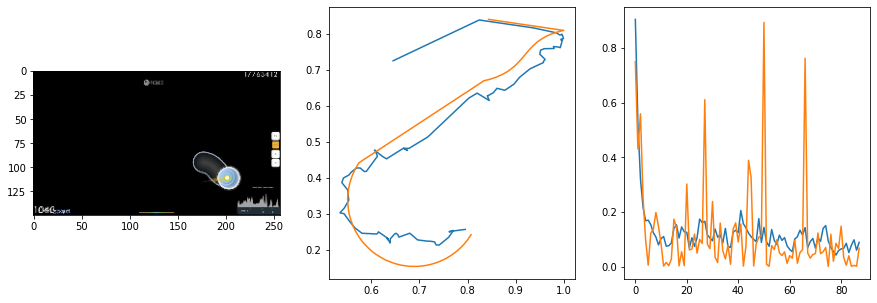

357.4243063926697 secs


In [19]:
start = time.time()

lamb = 1
epochs = 64
trainVN()

end = time.time()
print(end - start, 'secs')

In [ ]:
start = time.time()

lamb = 1
epochs = 64
trainVN()

end = time.time()
print(end - start, 'secs')

In [20]:
torch.save(vn.state_dict(), model_path + str(epoch_cum) + '.pt')

# Test Model

In [21]:
import os
import cv2
import torch
import torchvision.transforms as transforms

In [22]:
vn.load_state_dict(torch.load(model_path + str(88) + '.pt'))

<All keys matched successfully>

In [23]:
#osud = '../ex/beatmaps/567301 LamazeP - Spam Jack'
#osuf = 'LamazeP - Spam Jack (OsuToothbrush) [SPAM].osu'
#osud = '../ex/beatmaps/252981 DJ Okawari - Flower Dance (Short Ver)'
#osuf = 'DJ Okawari - Flower Dance (Short Ver.) (-Hanayuki-) [Relax].osu'
#osud = '../ex/beatmaps/348381 sasakureUK - Spider Thread Monopoly feat Hatsune Miku'
#osuf = 'sasakure.UK - Spider Thread Monopoly feat. Hatsune Miku (Mishima Yurara) [Milan-\'s Hard].osu'
#osud = '../demo/beatmaps/835194 Mili - Vulnerability'
#osuf = 'Mili_-_Vulnerability_IceKalt_Saturnalizes_Insane.osu'
#osud = '../demo/beatmaps/653534 Panda Eyes - ILY'
#osuf = 'Panda Eyes - ILY (M a r v o l l o) [Light Insane].osu'
osud = '../demo/beatmaps/388036 Akiyama Uni - Kanpan Tasogare Shinbun'
osuf = 'Akiyama Uni - Kanpan Tasogare Shinbun (09kami) [Insane].osu'

In [24]:
osr = OSR(osud, osuf, sample_rate=sample_rate, hop_size=hop_size, skin='./skin_hidden', vtmp='../demo/vids/')

In [25]:
osr.create_vid()

***********************************************************
['ffmpeg', '-y', '-loglevel', 'info', '-thread_queue_size', '24', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1024x600', '-pix_fmt', 'yuv420p', '-r', '50.00', '-an', '-i', '-', '-i', '/tmp/92ef5f8a-b7b1-11ec-b98e-a85e4554c351temp/audio.mp3', '-acodec', 'aac', '-vcodec', 'mjpeg', '-preset', 'fast', '-crf', '18', '-ab', '320k', '-threads', '0', '../demo/vids/Akiyama Uni - Kanpan Tasogare Shinbun (09kami) [Insane].osu.avi']
***********************************************************


In [26]:
video_path = os.path.join('../demo/vids/', osuf + '.avi')

In [27]:
vn.to(device)
vn.init_hidden(1)
vn.eval()

VN(
  (convA1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convB1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPB1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (convA2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convB2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPB2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (convA3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convB3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPB3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (lstmA): LSTM(38912, 128, batch_first=True)
  (linearA): Linear(in_features=128, out_features=32, bias=True)
  (linearB): Linear(in_features=32, out_features=2, bias=True)
)

In [28]:
transform = transforms.ToTensor()
frames = []
vc = cv2.VideoCapture(video_path)
p = []
while True:
    r, f = vc.read()
    if r is False:
        break
    f = cv2.resize(f, (0,0), fx=scale, fy=scale)
    F = transform(f).to(device)
    with torch.no_grad():
        P = vn(F.unsqueeze(0).unsqueeze(0))
    p.append(P.squeeze(0).squeeze(0).cpu().detach().numpy())

# Create Replay Video

In [29]:
from IPython.display import Video

In [30]:
np.save('predVN.npy', p)

In [31]:
eosud = osud.replace('/', '\/')

In [32]:
!sed -i "s/Beatmap path.*/Beatmap path\": \"$eosud\/$osuf\",/" data.json
!sed -i "s/Output path.*/Output path\": \"videoVN.mp4\",/" data.json

In [33]:
!python create_replayVN.py predVN.npy 50

2022-04-08 23:03:35,318:INFO:osr2mp4.Osr2mp4:__init__:test
2022-04-08 23:03:35,318:TRACE:osr2mp4.Utils.Setup:setupglobals:CALL *({'osu! path': '', 'Skin path': 'skin/', 'Beatmap path': '../demo/beatmaps/388036 Akiyama Uni - Kanpan Tasogare Shinbun/Akiyama Uni - Kanpan Tasogare Shinbun (09kami) [Insane].osu', '.osr path': 'auto', 'Default skin path': 'skin/', 'Output path': 'videoVN.mp4', 'Width': 1024, 'Height': 600, 'FPS': 30, 'Start time': 0, 'End time': -1, 'Video codec': 'mjpeg', 'Process': 0, 'ffmpeg path': 'ffmpeg'}, {'Show score meter': True, 'Always show key overlay': True, 'Song volume': 100, 'Effect volume': 100, 'Enable PP counter': True, 'Enable Strain Graph': True, 'FFmpeg codec': 'libx264', 'FFmpeg custom commands': '', 'Audio bitrate': 320, 'api key': None, 'Use FFmpeg video writer': True, 'Custom mods': ''}, [], <osr2mp4.global_var.Settings object at 0x7f922888b550>) **{'ppsettings': {'x': 1220, 'y': 690, 'text_x': 1140, 'text_y': 748, 'Font Size': 20, 'Size': 10, 'Rgb'

In [34]:
Video("videoVN.mp4")

In [ ]:
!sed -i "s/Output path.*/Output path\": \"video.mp4\",/" data.json

In [ ]:
!python create_replay.py predHN.npy predVN.npy 50 0.5

2022-04-05 01:28:27,439:INFO:osr2mp4.Osr2mp4:__init__:test
2022-04-05 01:28:27,439:TRACE:osr2mp4.Utils.Setup:setupglobals:CALL *({'osu! path': '', 'Skin path': 'skin/', 'Beatmap path': "../ex/beatmaps/348381 sasakureUK - Spider Thread Monopoly feat Hatsune Miku/sasakure.UK - Spider Thread Monopoly feat. Hatsune Miku (Mishima Yurara) [Milan-'s Hard].osu", '.osr path': 'auto', 'Default skin path': 'skin/', 'Output path': 'video.mp4', 'Width': 1024, 'Height': 600, 'FPS': 30, 'Start time': 0, 'End time': -1, 'Video codec': 'mjpeg', 'Process': 0, 'ffmpeg path': 'ffmpeg'}, {'Show score meter': True, 'Always show key overlay': True, 'Song volume': 100, 'Effect volume': 100, 'Enable PP counter': True, 'Enable Strain Graph': True, 'FFmpeg codec': 'libx264', 'FFmpeg custom commands': '', 'Audio bitrate': 320, 'api key': None, 'Use FFmpeg video writer': True, 'Custom mods': ''}, [], <osr2mp4.global_var.Settings object at 0x7f5a2cedf580>) **{'ppsettings': {'x': 1220, 'y': 690, 'text_x': 1140, 'tex

In [ ]:
Video("video.mp4")